# Week-05: Based on Week-03 materials (now with Tensorflow)
## Based on Kaggle's competition: Digit Recognizer
### and an article by Jonathan Weisberg
- Link to the Digit recognizer competition [Link here](https://www.kaggle.com/c/digit-recognizer/data)
- Link to the post by Jonathan Weisberg [Part 1](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/) [Part 2](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%202/)


### Data Description
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.



Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

<pre>
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
</pre>


The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

<pre>
ImageId,Label
1,3
2,7
3,8 
(27997 more lines)
</pre>

The evaluation metric for this contest is the `categorization accuracy`, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## Week - 05 material
import tensorflow
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.8.0


## Finding access to GPUs

We've mentioned GPUs plenty of times throughout this notebook.

So how do you check if you've got one available?

You can check if you've got access to a GPU using [`tf.config.list_physical_devices()`](https://www.tensorflow.org/guide/gpu).

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


If the above outputs an empty array (or nothing), it means you don't have access to a GPU (or at least TensorFlow can't find it).

If you're running in Google Colab, you can access a GPU by going to *Runtime -> Change Runtime Type -> Select GPU* (**note:** after doing this your notebook will restart and any variables you've saved will be lost).

Once you've changed your runtime type, run the cell below.

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


If you've got access to a GPU, the cell above should output something like:

`[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]`

You can also find information about your GPU using `!nvidia-smi`.

In [ ]:
!nvidia-smi

Thu Feb 17 13:42:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> 🔑 **Note:** If you have access to a GPU, TensorFlow will automatically use it whenever possible.

In [ ]:
#Test if the code is running on Google colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
#if on google drive
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  mnist_path = '/content/gdrive/MyDrive/Colab Notebooks/csci5931sp22/'
else:
  mnist_path = ''

Mounted at /content/gdrive


In [ ]:
#Loading the training and test dataset... also the submission_df
dataset = pd.read_csv(mnist_path + 'mnist-dataset/train.csv')
#test_df = pd.read_csv('mnist-dataset/test.csv')
#submission_df = pd.read_csv('mnist-dataset/sample_submission.csv')

In [ ]:
dataset.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [ ]:
X = dataset.drop('label',axis=1)
y = dataset['label']

In [ ]:
X.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

In [ ]:
len(y)

42000

### Checking if there is an issue of class imbalance

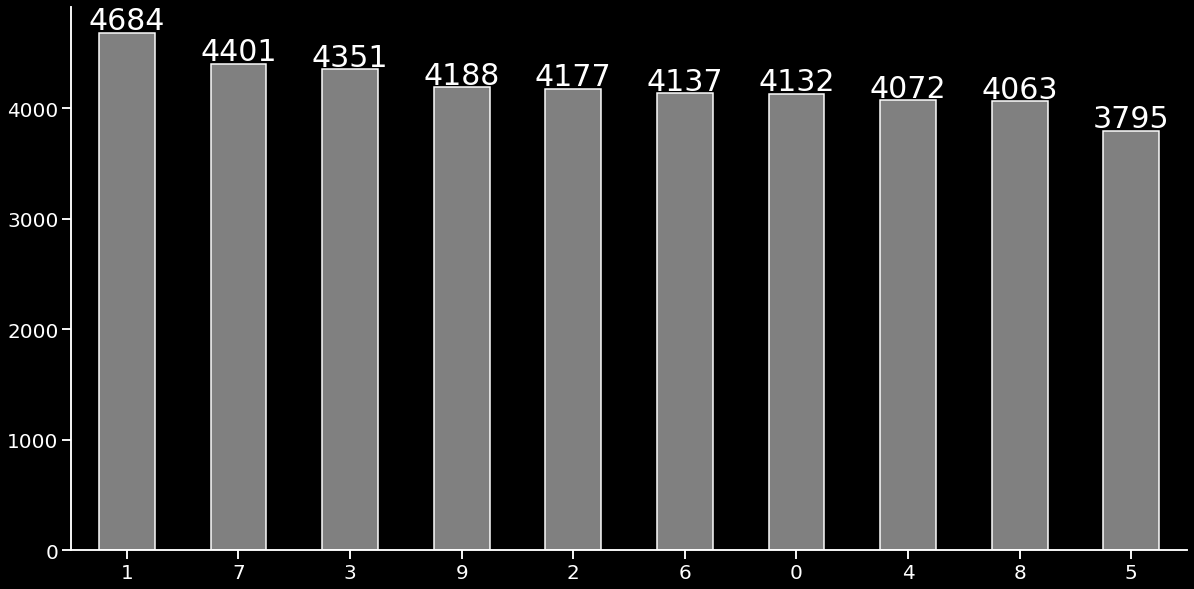

In [ ]:
sns.set(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")
plt.figure(figsize = (20,10))
ax = y.value_counts().sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.xticks(rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 30, height, ha = 'center', size = 30)
sns.despine()

### Comment on the numbers above

* All numbers appear to be balanced. So, I declare "No problem!"
* 1 is the most and 5 is the least.

### Let's draw a few samples from train set

In [ ]:
%matplotlib inline
# display k number of random mnist samples
k = 10
n = len(X) #total number of samples in the dataset

perm_indices_k = np.random.permutation(n)[:k] #shuffle samples

#Now the plot them 5 per row
fig = plt.figure(figsize=(25, 4))
img = np.array(X.iloc[perm_indices_k]).reshape(-1, 28, 28)
fig = px.imshow(img,
                color_continuous_scale='Blues_r',
                facet_col=0, 
                binary_string=True, 
                facet_col_wrap=5,
                labels = {'facet_col':'img'}
               )
fig.show()

<Figure size 1800x288 with 0 Axes>

Label = 1


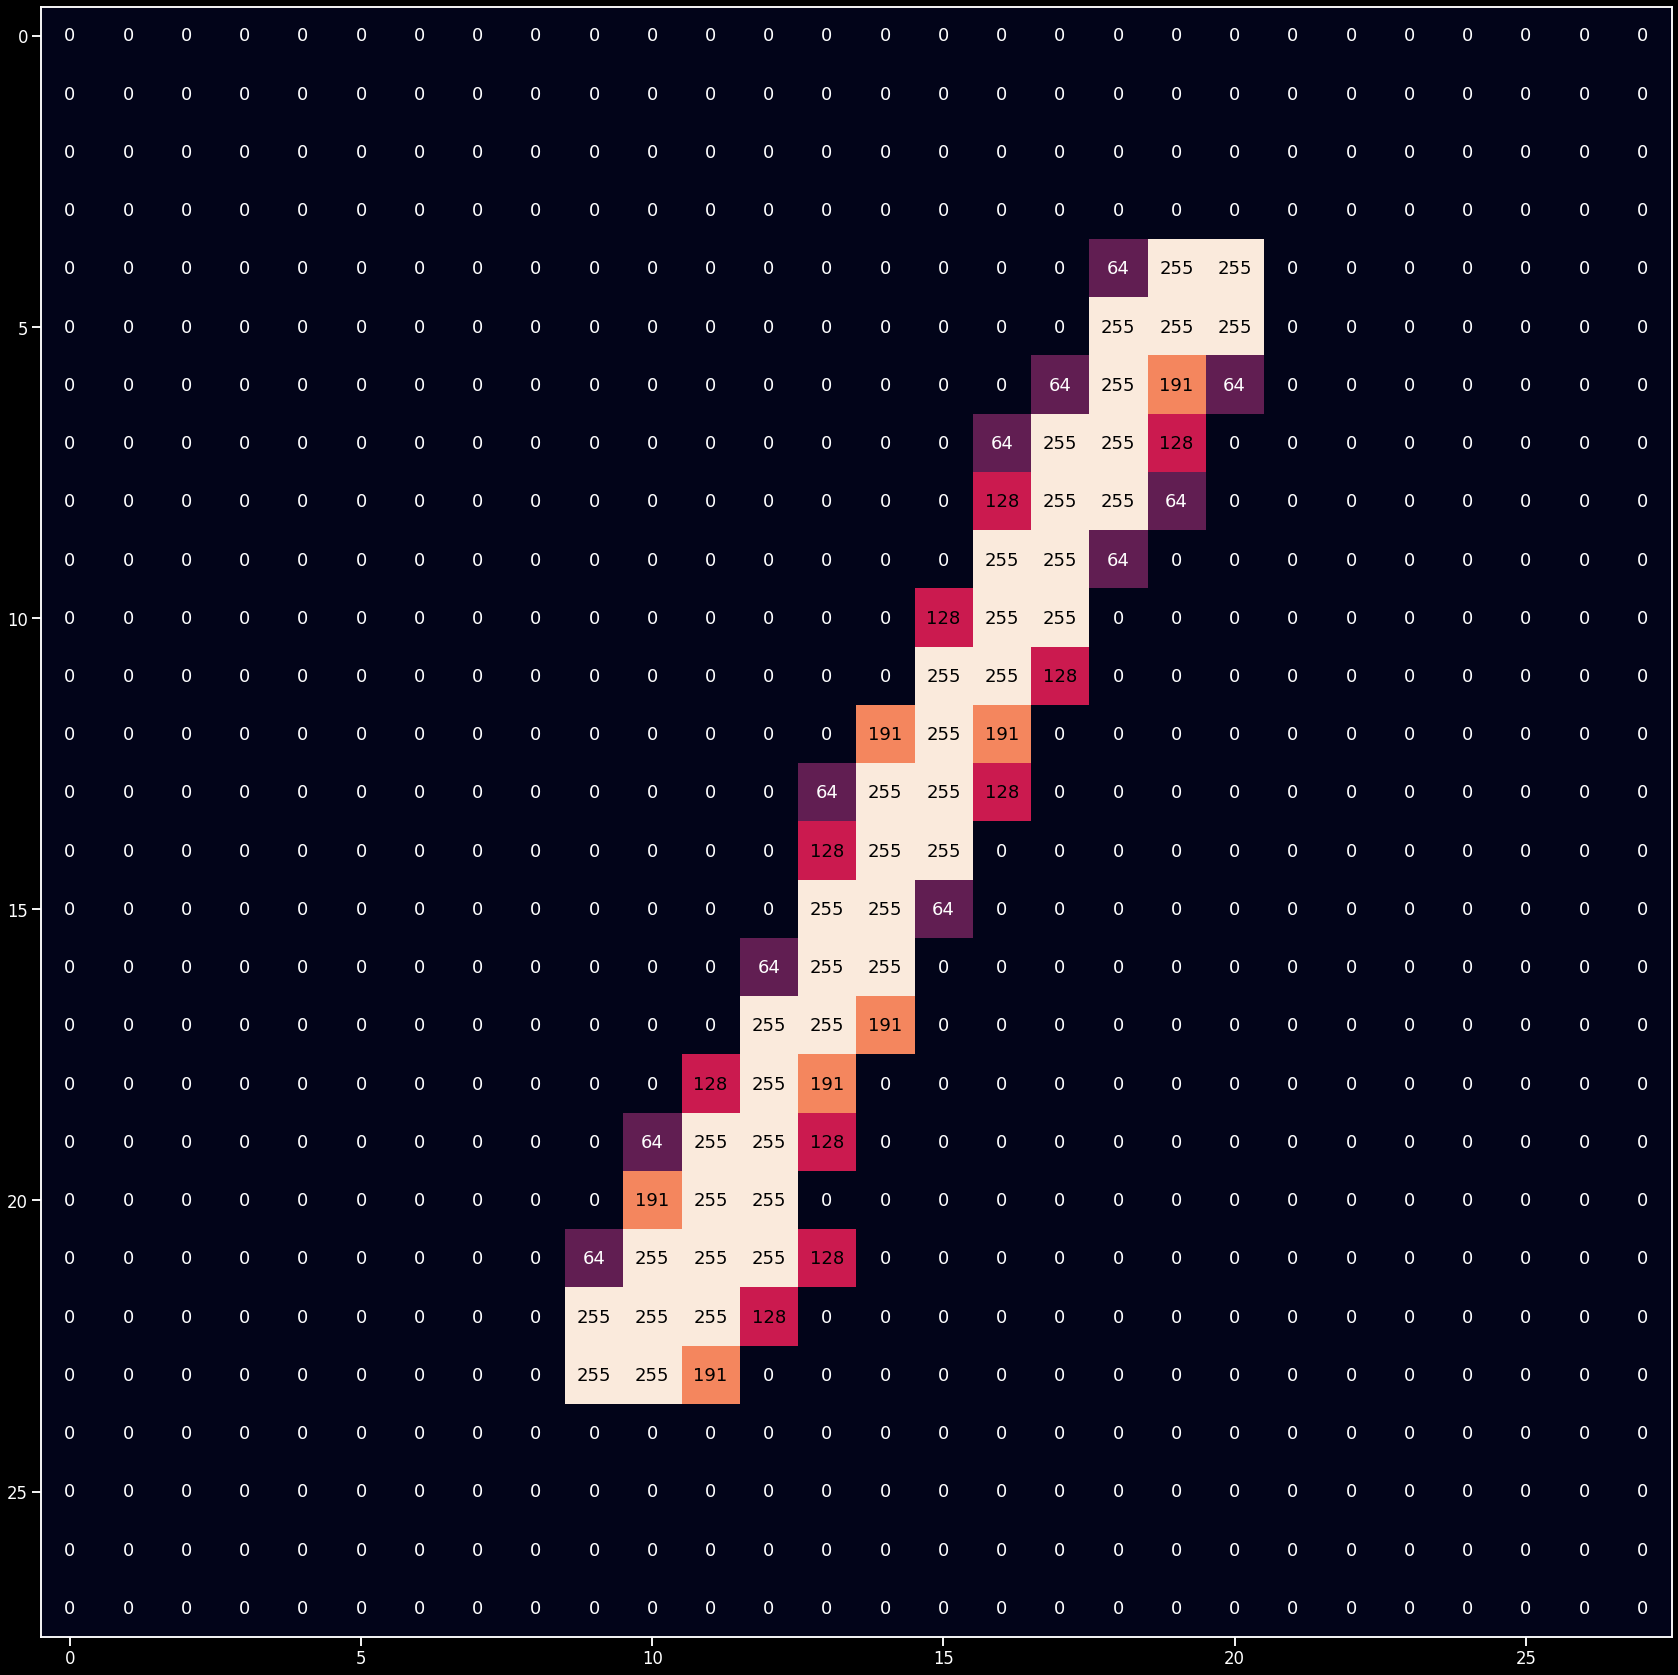

In [ ]:
### More into drawing a random sample
a_sample_x = X.sample(1)
a_sample_y = int(y[a_sample_x.index])
print('Label = {}'.format(a_sample_y))

img = np.array(a_sample_x)[0].reshape( 28, 28)
sns.set(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")
fig = plt.figure(figsize = (30,30)) 
ax = fig.add_subplot(111)
ax.imshow(img)
width, height = img.shape
thresh = img.max()/2.5
for w in range(width):
    for h in range(height):
        val = round(img[w][h],2) if img[w][h] !=0 else 0
        ax.annotate(str(val), xy=(h,w),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[w][h]<thresh else 'black')

## MNIST : Building a Neural Network (v1)
* Let's solve a simple binary classification problem around MNIST -- digit 0, or not. 
    * If a given image has label '0', the target class label would be 'True' (i.e., 1)
    * Otherwise, 'False' (i.e., 0)
    * That is, we are pretty much building a 0-digit recognizer.
* The neural network we will build has just one neuron (at the output layer) -- no hidden layer.

### Step v1.1 We normalize the data to keep our gradients manageable

In [ ]:
X = np.array(X / 255.0)

### Step v1.2 Convert dataset for the binary classification problem
* The default MNIST labels record 7 for an image of a seven, 4 for an image of a four, and so on.
* But, we are building a zero-digit recognizer in version 1 (v1). 
* So, we want our labels to say 1 when we have a zero digit, and 0 otherwise.
* Therefore, we need to overwrite the labels to make that happen.

In [ ]:
y_new = np.zeros(y.shape)
y_new[np.where(y==0.0)[0]] = 1
y = y_new

### Step v1.3 Train-test split of the X,y dataset
* 80%-20% train-test split of the X,y dataset
* We also transform the shape of dataset so that each sample are placed in a column instead of row. This will ease matrix operations

In [ ]:
n = len(X) #total number of samples in the dataset
m = int(n*0.8) #80% of total samples will go to the training set, and rest will go to test set.
m_test = X.shape[0] - m #The rest, i.e., 20% will go to test.

In [ ]:
#Now split the X, y into (X_train,y_train), and (X_test,y_test) tuples
X_train, X_test = X[:m].T, X[m:].T
y_train, y_test = y[:m].reshape(1,m), y[m:].reshape(1,m_test)

In [ ]:
#And, shuffle the training set
np.random.seed(4321)
shuffle_indices = np.random.permutation(m)
X_train, y_train = X_train[:,shuffle_indices], y_train[:,shuffle_indices]

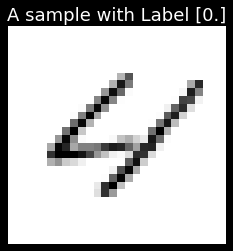

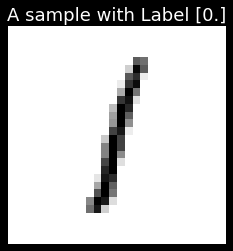

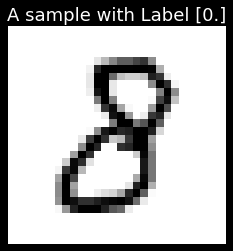

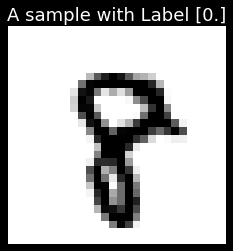

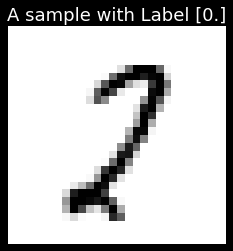

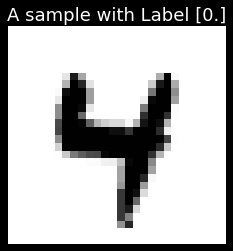

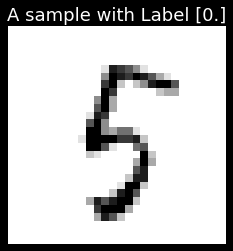

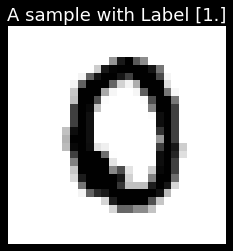

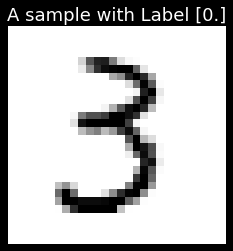

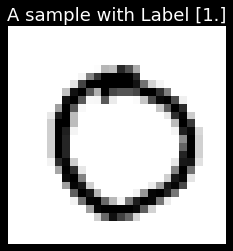

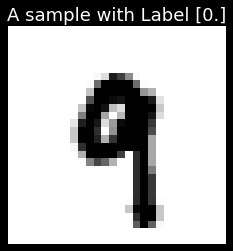

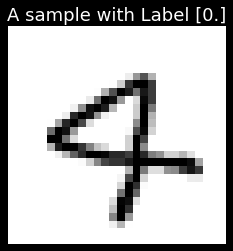

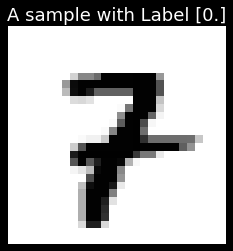

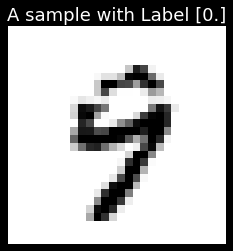

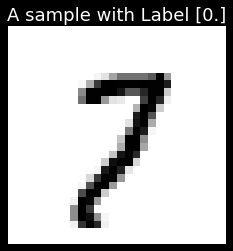

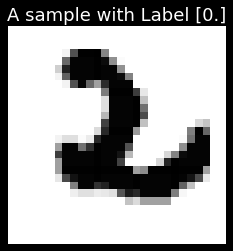

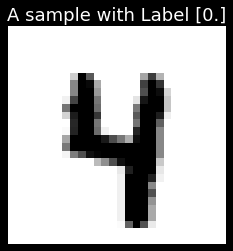

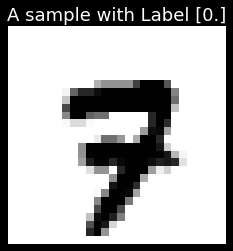

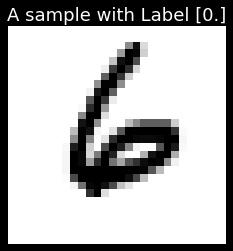

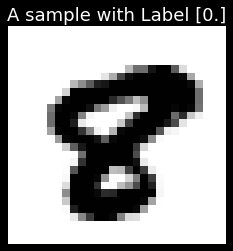

In [ ]:
#Print a random sample
for idx in range(20):
    plt.imshow(X_train[:,idx].reshape(28,28),cmap=matplotlib.cm.binary)
    plt.axis('off')
    plt.title('A sample with Label {}'.format(y_train[:,idx]))
    plt.show()
    #print(y_train[:,idx])

### Step v1.4: Constructing the 1-neuron ANN
* It's a feed-forward network with 784 (=$28\times 28$), and single sigmoid neuron generating the output.

![1-neuron-ANN](http://54.160.44.72/csci5931sp22/figs/ann-01.gvz.png)

### Step v1.4.1: Defining the forward propagation
The forward pass on a single example $x$ executes the following computation:
$$
\hat{y} = \sigma(w^Tx + b),
$$
where 
* $w$ is the weight vector of dimension $784$, 
* $x$ is a vector of an input sample of dimension $784$, and 
* $b$ is the bias. 

$\sigma$ is the sigmoid activation function: $\sigma(z) = \dfrac{1}{1 + e^{-z}}$

Let's first define the sigmoid function:

In [ ]:
""" The sigmoid function that squashes input, z into the range [0,1] """
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [ ]:
## Week 05 material (with tensorflow)

""" The sigmoid function that squashes input, z into the range [0,1] """
@tf.function
def TF_sigmoid(z):
    s = tf.divide( tf.constant(1.0), tf.add(tf.constant(1.0),tf.exp(tf.negative(z))) )
    return s

In [ ]:
sigmoid(1.32)

0.789181706522253

In [ ]:
TF_sigmoid(1.32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7891817>

* We will vectorize by stacking samples side-by-side, so that our input matrix, $X$ has a sample in each column.
* The shape of $X$ will become: $784 \times m$, where $m$ is the number of samples in training.
* The shape of $w$ will be: $784\times 1$, i.e., a column-vector of size 784.
* The shape of $b$ is 1.
* Now, the vectorized form of the forward pass is then:
$$
\hat{y} = \sigma(w^TX + b)
$$
* Here, the shape of $\hat{y}$ should be $1\times m$, i.e., an $m$ dimensional row vector, containing the predicted $y$ values for the $m$ samples.
* In our code, we will compute this in 2 stages:
`z = np.matmul(w.T, X) + b`
    * `Z` is the net input (i.e., weighted sum calculated at the neuron.
    
* and then, we will do:
`A = sigmoid(z)`
    * `A` for activation.

## A note on gradient descent algorithm to optimize a cost function, L
![gd-intuition](http://54.160.44.72/csci5931sp22/figs/gd-intuition-2.png)

* If slope, $\dfrac{\partial L}{\partial w} \geq 0$
    * we are on the right side of optimum, $L$. So, we need to decrease $w$ **a little bit**.
    * We do this using the gradient update:
    $$
    w = w - \alpha \dfrac{\partial L}{\partial w}
    $$
    where, $\alpha$ is called the learning rate.
* If slope, $\dfrac{\partial L}{\partial w} < 0$
    * we are on the left side of optimum, $L$. So, we need to increase $w$ **a little bit**.
    * We do this using the same gradient update:
    $$
    w = w - \alpha \dfrac{\partial L}{\partial w}
    $$
* Please note, the above two gradient updates are actually the same statement.

### Step v1.4.2 Defining the Cost (or, Loss) function
* We will use cross-entropy for our cost function. The idea of this cost function is the same from `logistic regression`:
![cross-entropy-loss-plot](figs/cross-entropy-loss-plot.jpg)

$\text{cost}\left(h_{w,b}(\mathbf{x}),y\right) = $
	$$ 
    \begin{cases} 
    -\log (h_{w,b}(\mathbf{x}) ) & \text{if}\quad y=1 \\
    -\log (1-h_{w,b}(\mathbf{x}) ) & \text{if}\quad y=0
\end{cases}
    $$
where, $h_{w,b}(\mathbf{x}) = \hat{y} = w^Tx + b$

* Let's rewrite the above cost function using $\hat{y}$:
$\text{cost}(\hat{y},y) = $

	$$ 
        \begin{cases} 
    -\log\hat{y} & \text{if}\quad y=1 \\
    -\log\left(1-\hat{y}\right) & \text{if}\quad y=0
    \end{cases}
    
    $$

* Key property of this cross-entropy cross-function is:
    1. It's convex-looking, so a gradient descent algorithm can expect an optimum solution.
    2. Cost=0, if $y=1, \hat{y}=1$, 
    3. As $\hat{y}\rightarrow 0$, cost$\rightarrow\infty$
        * If $\hat{y}=0$, i.e., $pr(y=1|x,w,b)=0$, but the true value is, $y=1$, we can expect a much high cost as penalty.
		* Similarly, if $\hat{y}=1$, i.e., $pr(y=0|x,w,b)=1$, when the ground true value is $y=0$, we should penalize the algorithm by a very high cost.

* The cross-entropy cost function can be simplified to the following to enforce the 2 conditions on $y$:
$$
\text{cost}(\hat{y},y) = \begin{cases} 
	-y\log(\hat{y})& \text{if}\quad y=1 \\
	-(1-y)\log(1-\hat{y})& \text{if}\quad y=0 
	\end{cases}
$$

* Now, let's combine the two pieces of the piece-wise cost function above, that would yield the same cost value as in the original cost function:
$$
\text{cost}(\hat{y},y) = -y\log(\hat{y})-(1-y)\log(1-\hat{y})
$$

* Let's call $cost(\hat{y},y)$ $L(\hat{y},y)$ from now on for notational simplicity only, $L$ would mean "Loss".

$$
L(\hat{y},y) = -y\log(\hat{y})-(1-y)\log(1-\hat{y})
$$


* Averaging over all the $m$ samples in a training set, we get:

$$
L(\hat{y},y) = -\dfrac{1}{m}\sum_{i=1}^m \left( y\log(\hat{y})+(1-y)\log(1-\hat{y})\right)
$$


* We are now ready to define the cross-entropy loss function. So, let's do it then:

In [ ]:
def compute_cross_entropy_loss(y_hat, y):
    m = y.shape[1] #number of samples
    L = -(1./m) * ( 
            np.sum( np.multiply(np.log(y_hat),y) ) + 
            np.sum( np.multiply(np.log(1-y_hat),(1-y)) ) )
    return L


In [ ]:
## Week-05 material
@tf.function
def TF_compute_cross_entropy_loss(y_hat, y):
    m = y.shape[1] #number of samples
    #L = -(1./m) * ( 
    #        np.sum( np.multiply(np.log(y_hat),y) ) + 
    #        np.sum( np.multiply(np.log(1-y_hat),(1-y)) ) )
    

    L = tf.multiply( tf.negative(tf.divide(tf.constant(1.0),tf.cast(tf.constant(m),dtype=tf.float32))), 
                    tf.add( tf.reduce_sum(tf.multiply(tf.math.log(y_hat),y)),
                            tf.reduce_sum(tf.multiply(tf.subtract(tf.constant(1.0),y),
                                        tf.math.log(tf.subtract(tf.constant(1.0),y_hat))
                                       ))
                          )
                   )
    return L


In [ ]:
# Create 2 tensors with 50 random values between 0 and 100
y1 = tf.cast(tf.constant(np.random.rand(10,50)),dtype=tf.float32)
y2 = tf.cast(tf.constant(np.random.rand(10,50)),dtype=tf.float32)

In [ ]:
TF_compute_cross_entropy_loss(y1,y2)

<tf.Tensor: shape=(), dtype=float32, numpy=9.794844>

In [ ]:
#it's the same as numpy version of cross-entropy calculation, isn't it?
compute_cross_entropy_loss(y1.numpy(),y2.numpy())

9.79484375

### Step v1.4.3: Defining backpropagation
* For backpropagation, we will need to know how $L$ changes with respect to each component $w_j$ of the vector $w$. That is, we must compute each of the $\dfrac{\partial L}{\partial w_j}$
* Holding all values except $w_j$ fixed, we can think of $L$ being computed in three steps:
    * $w_j \rightarrow z \rightarrow \hat{y} \rightarrow L$

* The formulas for these steps are:
$$
\begin{align*}
\nonumber z &=& w^Tx + b\\
\nonumber \hat{y} &=& \sigma(z)\\
\nonumber L(\hat{y},y) &=& -y\log(\hat{y})-(1-y)\log(1-\hat{y})
\end{align*}
$$

* And the chain rule of differentiation says:
$$
\dfrac{\partial L}{\partial w_j} =  \dfrac{\partial L}{\partial \hat{y}}\dfrac{\partial \hat{y}}{\partial z}\dfrac{\partial z}{\partial w_j}
$$

* Let's first look at $\dfrac{\partial L}{\partial \hat{y}}$
$$
\begin{align*}
\nonumber \dfrac{\partial L}{\partial \hat{y}} &=& \dfrac{\partial}{\partial \hat{y}}\left(-y\log(\hat{y})-(1-y)\log(1-\hat{y}) \right)\\
\nonumber &=& -y\dfrac{\partial }{\partial \hat{y}}\log(\hat{y}) - (1-y)\dfrac{\partial}{\partial \hat{y}}\log(1-\hat{y})\\
\nonumber &=& -y\left(\dfrac{1}{\hat{y}}\right) - (1-y)\left(\dfrac{-1}{1-\hat{y}}\right)\\
\nonumber &=& \dfrac{-y}{\hat{y}} + \dfrac{(1-y)}{(1-\hat{y})}\\
\nonumber &=& \dfrac{-y(1-\hat{y})+\hat{y}(1-y)}{\hat{y}(1-\hat{y})}\\
\nonumber &=& \dfrac{-y+y\hat{y}+\hat{y}-y\hat{y}}{\hat{y}(1-\hat{y})}\\
\nonumber &=& \dfrac{\hat{y}-y}{\hat{y}(1-\hat{y})}
\end{align*}
$$

* Next, we will calculate $\dfrac{\partial \hat{y}}{\partial z}$
$$
\begin{align*}
\nonumber \dfrac{\partial \hat{y}}{\partial z} &=& \dfrac{\partial \sigma(z)}{\partial z}\\
\nonumber &=& \dfrac{\partial }{\partial z}\left( \dfrac{1}{1+e^{-z}}\right)\\
\nonumber &=& \dfrac{-1}{(1+e^{-z})^2}\dfrac{\partial }{\partial z}\left(1 + e^{-z}\right)\\
\nonumber &=& \dfrac{-1}{(1+e^{-z})^2}{(-e^{-z})}\\
\nonumber &=& \dfrac{e^{-z}}{(1+e^{-z})^2}\\
\nonumber &=& \dfrac{1+e^{-z}-1}{(1+e^{-z})^2}\\
\nonumber &=& \dfrac{1+e^{-z}}{(1+e^{-z})^2} - \dfrac{1}{(1+e^{-z})^2}\\
\nonumber &=& \dfrac{1}{1+e^{-z}}-\dfrac{1}{(1+e^{-z})^2}\\
\nonumber &=& \sigma(z) - \sigma(z)^2\\
\nonumber &=& \sigma(z)(1-\sigma(z))\\
\nonumber &=& \hat{y}(1-\hat{y})
\end{align*}
$$

* Finally, let's calculate $\dfrac{\partial z}{\partial w_j}$
$$
\begin{align*}
\nonumber \dfrac{\partial z}{\partial w_j} &=& \dfrac{\partial}{\partial w_j}\left(w^Tx + b\right)\\
\nonumber &=& \dfrac{\partial}{\partial w_j}\left(w_0x_0 + w_1x_1 + \cdots + w_jx_j+\cdots + w_nx_n + b\right)\\
\nonumber &=& x_j
\end{align*}
$$

* We can now substitute these three derivatives into the chain rule:
$$
\begin{align*}
\dfrac{\partial L}{\partial w_j} &=&  \dfrac{\partial L}{\partial \hat{y}}\dfrac{\partial \hat{y}}{\partial z}\dfrac{\partial z}{\partial w_j}\\
\nonumber &=& \dfrac{\hat{y}-y}{\hat{y}(1-\hat{y})}\hat{y}(1-\hat{y})x_j\\
\nonumber &=& (\hat{y}-y)x_j
\end{align*}
$$

* In vectorized form over $m$ training samples gives us:
$$
\dfrac{\partial L}{\partial w} = \dfrac{1}{m}X(\hat{y}-y)^T
$$

* What about $\dfrac{\partial L}{\partial b}$ ? If you'd follow the similar math above, we will get the following for a single sample:
$$
\dfrac{\partial L}{\partial b} = (\hat{y}-y)
$$

which in vectorized form would transform to:
$$
\dfrac{\partial L}{\partial b} = \dfrac{1}{m}\sum_{i=1}^m\left( \hat{y}^{(i)}-y^{(i)} \right)
$$
where, $\hat{y}^{(i)}, y^{(i)}$ be the prediction and ground true labels of the $i^\text{th}$ training sample.

* In our code, we will label $\dfrac{\partial L}{\partial w}$ and $\dfrac{\partial L}{\partial b}$ as `dW` and `db`.

### Step v1.4.4 Build and train
* Okay? We are ready to do it now.

In [ ]:
learning_rate = 1.0

X = X_train
y = y_train

In [ ]:
n_x = X.shape[0] #number of variables per training sample
m = X.shape[1] #number of samples in the training set, X

In [ ]:
W = np.random.randn(n_x,1)* 0.01 #The weight vector
b = np.zeros((1,1)) #The bias weight vector
print('Shape of the weight vector, W is {}'.format(W.shape))
print('Shape of the bias weight, b is {}'.format(b.shape))

Shape of the weight vector, W is (784, 1)
Shape of the bias weight, b is (1, 1)


In [ ]:
max_iter = 2000 #Maximum number of iterations you want

progress_bar = tqdm(range(max_iter))

for i in progress_bar:

    Z = np.matmul(W.T,X) + b  #The net_in
    A = sigmoid(Z)            #Activation output, hat(y)
    
    cost = compute_cross_entropy_loss(A, y)
    
    #compute the 2 derivatives, dW, db
    dW = (1/m)* np.matmul(X, (A-y).T)
    db = (1/m)* np.sum(A-y, axis=1, keepdims=True)
    
    #Weight update
    W = W - learning_rate * dW
    b = b - learning_rate * db
    
    
    #debug point
    if (i % 100 == 0):
        #print('Epoch [{}]: Cost [{}]'.format(i,cost))
        progress_bar.set_description('Epoch [{}]: Cost [{}]'.format(i,cost))
        
print('Final cost = {}'.format(cost))

Epoch [1900]: Cost [0.022148242674021625]: 100%|██████████| 2000/2000 [01:27<00:00, 22.94it/s]

Final cost = 0.021984795669552


* We could probably seek out a bit more accuracy with some more training by setting `max_iter` to higher numbers. But, note that the gains have slowed down considerably. So, let's just see how we did, by looking at the confusion matrix after evaluating on the test dataset.

In [ ]:
## Week-05 material

tf.config.run_functions_eagerly(True)

print(tf.executing_eagerly())


True


True


In [ ]:
## Week-05 material

TF_X = tf.Variable(X_train,dtype=tf.float32)
TF_X

True


<tf.Variable 'Variable:0' shape=(784, 33600) dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
TF_y = tf.Variable(y_train, dtype=tf.float32)
TF_y

<tf.Variable 'Variable:0' shape=(1, 33600) dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
TF_W = tf.Variable(np.random.randn(n_x,1)* 0.01, dtype=tf.float32) #The weight vector
TF_b = tf.Variable(np.zeros((1,1)),dtype=tf.float32) #The bias weight vector
print('Shape of the weight vector, W is {}'.format(TF_W.shape))
print('Shape of the bias weight, b is {}'.format(TF_b.shape))

Shape of the weight vector, W is (784, 1)
Shape of the bias weight, b is (1, 1)


In [ ]:
max_iter = 2000 #Maximum number of iterations you want

progress_bar = tqdm(range(max_iter))

for i in progress_bar:
    #Z = np.matmul(W.T,X) + b  #The net_in

    TF_Z = tf.add(tf.matmul(tf.transpose(TF_W),TF_X),TF_b)
    TF_A = TF_sigmoid(TF_Z)            #Activation output, hat(y)

    
    cost = TF_compute_cross_entropy_loss(TF_A, TF_y)
    
    #compute the 2 derivatives, dW, db
    #dW = (1/m)* np.matmul(X, (A-y).T)
    TF_dW = tf.multiply( tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32)),
                      tf.matmul(TF_X,tf.transpose(tf.subtract(TF_A,TF_y)))
                    )
    #db = (1/m)* np.sum(A-y, axis=1, keepdims=True)
    TF_db = tf.multiply( tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32)),
                         tf.reduce_sum(tf.subtract(TF_A,TF_y),axis=1,keepdims=True)
                       )
    
    #Weight update
    TF_W = tf.subtract(TF_W,tf.multiply(tf.constant(learning_rate,dtype=tf.float32), TF_dW))
    TF_b = tf.subtract(TF_b,tf.multiply(tf.constant(learning_rate,dtype=tf.float32), TF_db))
    
    
    #debug point
    if (i % 100 == 0):
        #print('Epoch [{}]: Cost [{}]'.format(i,cost))
        progress_bar.set_description('Epoch [{}]: Cost [{}]'.format(i,cost))
        
print('Final cost = {}'.format(cost))

Epoch [1900]: Cost [0.022149477154016495]: 100%|██████████| 2000/2000 [00:07<00:00, 282.46it/s]

Final cost = 0.021985668689012527


### Step v1.4.5 Evaluation

In [ ]:
# Feed forward test dataset onto the network, with W, b trained.
TF_X = tf.Variable(X_test,dtype=tf.float32)
TF_y = tf.Variable(y_test,dtype=tf.float32)

TF_Z = tf.add( tf.matmul( tf.transpose(TF_W), TF_X), TF_b) #the net_in
TF_A = TF_sigmoid(TF_Z)                  #activated output, hat(y), the prediction
A = TF_A.numpy() #convert tensor back to numpy array

* Since the prediction, $A$ is a sigmoid output, ranging values between 0 and 1. 
* So, we need to translating it in-terms of probability:
    * any prediction above 0.50 should be called class "1" (True), i.e., the zero digit recognized.
    * otherwise, prediction will be called "0", i.e., the zero digit not recognized for a given sample.

In [ ]:
predictions = (A > 0.5)[0, :]  #our predictions
labels = (y_test == 1)[0,:]    #the ground-true class labels

In [ ]:
#Now, build the confusion matrix
conf_mat = confusion_matrix(predictions,labels)
print('Confusion matrix: \n{}'.format(conf_mat))

Confusion matrix: 
[[7517   35]
 [  31  817]]


* That's actually pretty good, right?
* Here is how to interpret from a confusion matrix:
<img src="http://54.160.44.72/csci5931sp22/figs/conf_mat.jpg" width=600/>


* And the classification report below. You can see the performance is extra-ordinarily good.

In [ ]:
print('Classification report on the test set: \n{}'.format(classification_report(predictions,labels)))

Classification report on the test set: 
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7552
        True       0.96      0.96      0.96       848

    accuracy                           0.99      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.99      0.99      0.99      8400



## Building a Neural Network (version 2)
* With a hidden layer having 64 units.
* I won't go through the derivations of all the formulas for the forward and backward passes this time.
    * They are pretty direct extension of the work we did earlier for version 1.
* Let's just dive right in and build the model

### Step v2.1 Build and train

In [ ]:
X = X_train
y = y_train

In [ ]:
n_x = X.shape[0]
n_h = 64           #number of units in hidden layer
learning_rate = 1

In [ ]:
#weight initialization
W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(1, n_h)
b2 = np.zeros((1, 1))

In [ ]:
max_iter = 2000

progress_bar = tqdm(range(max_iter))
for i in progress_bar:
    
    #Forward propagation
    Z1 = np.matmul(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = sigmoid(Z2)

    #compute cost
    cost = compute_cross_entropy_loss(A2, y)

    #compute the derivatives for each of the weight parameters
    dZ2 = A2-y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

    #gradient descent weight updates
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    #debug point
    if i % 100 == 0:
        progress_bar.set_description('Epoch [{}]: Cost [{}]'.format(i,cost))

print("\nFinal cost:", cost)

Epoch [0]: Cost [0.18649637868882202]:   1%|▏         | 26/2000 [00:20<25:46,  1.28it/s]


KeyboardInterrupt: ignored

In [ ]:
TF_X = tf.Variable(X_train, dtype=tf.float32)
TF_y = tf.Variable(y_train, dtype=tf.float32)

In [ ]:
n_x = X.shape[0]
n_h = 64           #number of units in hidden layer
learning_rate = 1

In [ ]:
#weight initialization
TF_W1 = tf.Variable(np.random.randn(n_h, n_x), dtype=tf.float32)
TF_b1 = tf.Variable(np.zeros((n_h, 1)), dtype=tf.float32)
TF_W2 = tf.Variable(np.random.randn(1, n_h), dtype=tf.float32)
TF_b2 = tf.Variable(np.zeros((1, 1)), dtype=tf.float32)

In [ ]:
max_iter = 2000

progress_bar = tqdm(range(max_iter))
for i in progress_bar:
    
    #Forward propagation
    #Z1 = np.matmul(W1, X) + b1
    TF_Z1 = tf.add( tf.matmul(TF_W1,TF_X), TF_b1)
    #A1 = sigmoid(Z1)
    TF_A1 = TF_sigmoid(TF_Z1)
    #Z2 = np.matmul(W2, A1) + b2
    TF_Z2 = tf.add( tf.matmul(TF_W2, TF_A1), TF_b2)
    #A2 = sigmoid(Z2)
    TF_A2 = TF_sigmoid(TF_Z2)

    #compute cost
    #cost = compute_cross_entropy_loss(A2, y)
    cost = TF_compute_cross_entropy_loss(TF_A2, TF_y)

    #compute the derivatives for each of the weight parameters
    #dZ2 = A2-y
    TF_dZ2 = tf.subtract(TF_A2, TF_y)
    #dW2 = (1./m) * np.matmul(dZ2, A1.T)
    TF_dW2 = tf.multiply( tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32)),
                                    tf.matmul(TF_dZ2, tf.transpose(TF_A1)))
    #db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)
    TF_db2 = tf.multiply(tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32)),tf.reduce_sum(TF_dZ2,axis=1,keepdims=True))

    #dA1 = np.matmul(W2.T, dZ2)
    TF_dA1 = tf.matmul(tf.transpose(TF_W2), TF_dZ2)
    #dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    TF_dZ1 = tf.multiply( tf.multiply(TF_dA1, TF_sigmoid(TF_Z1)), tf.subtract(tf.constant(1.),TF_sigmoid(TF_Z1)))
    #dW1 = (1./m) * np.matmul(dZ1, X.T)
    TF_dW1 = tf.multiply(tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32)), tf.matmul(TF_dZ1, tf.transpose(TF_X)))
    #db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)
    TF_db1 = tf.multiply(tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32)), tf.reduce_sum(TF_dZ1, axis=1,keepdims=True))

    #gradient descent weight updates
    #W2 = W2 - learning_rate * dW2
    TF_W2 = tf.subtract(TF_W2, tf.multiply(tf.constant(learning_rate, dtype=tf.float32),TF_dW2))
    #b2 = b2 - learning_rate * db2
    TF_b2 = tf.subtract(TF_b2, tf.multiply(tf.constant(learning_rate, dtype=tf.float32),TF_db2))
    #W1 = W1 - learning_rate * dW1
    TF_W1 = tf.subtract(TF_W1, tf.multiply(tf.constant(learning_rate, dtype=tf.float32),TF_dW1))
    #b1 = b1 - learning_rate * db1
    TF_b1 = tf.subtract(TF_b1, tf.multiply(tf.constant(learning_rate, dtype=tf.float32),TF_db1))

    #debug point
    if i % 100 == 0:
        progress_bar.set_description('Epoch [{}]: Cost [{}]'.format(i,cost))

print("\nFinal cost:", cost)

Epoch [1900]: Cost [0.022032838314771652]: 100%|██████████| 2000/2000 [00:24<00:00, 80.53it/s]


Final cost: tf.Tensor(0.02145777, shape=(), dtype=float32)


### Step v2.2 Evaluation

In [ ]:
# Feed forward test dataset onto the hidden layer, with W1, b1 trained.
TF_X = tf.Variable(X_test, dtype=tf.float32)

TF_Z1 = tf.add(tf.matmul(TF_W1, TF_X), TF_b1) #the net_in
TF_A1 = TF_sigmoid(TF_Z1)                  #activated output from the hidden layer
#now, feed forward the hidden layer output to the next layer, output layer
TF_Z2 = tf.add(tf.matmul(TF_W2,TF_A1), TF_b2)        #the net_in
TF_A2 = TF_sigmoid(TF_Z2)                  #activated output from the output layer, hat(y), the prediction

A2 = TF_A2.numpy() #convert it back to numpy

* Since the prediction, $A2$ is a sigmoid output, ranging values between 0 and 1. 
* So, we need to translating it in-terms of probability:
    * any prediction above 0.50 should be called class "1" (True), i.e., the zero digit recognized.
    * otherwise, prediction will be called "0", i.e., the zero digit not recognized for a given sample.

In [ ]:
predictions = (A2 > 0.5)[0, :]  #our predictions
labels = (y_test == 1)[0,:]    #the ground-true class labels

In [ ]:
#Now, build the confusion matrix
conf_mat = confusion_matrix(predictions,labels)
print('Confusion matrix: \n{}'.format(conf_mat))

Confusion matrix: 
[[7506   44]
 [  42  808]]


* That's actually pretty good, right?
* Here is how to interpret from a confusion matrix:
<img src="http://54.160.44.72/csci5931sp22/figs/conf_mat.jpg" width=600/>


* And the classification report below. You can see the performance is extra-ordinarily good.

In [ ]:
print('Classification report on the test set: \n{}'.format(classification_report(predictions,labels)))

Classification report on the test set: 
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      7550
        True       0.95      0.95      0.95       850

    accuracy                           0.99      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.99      0.99      0.99      8400



## Building a Neural Network (version 3)

* Now we are upgrading to multi-class. We have a 10-class classification problem for the 10-digits to recognize (digit 0, digit 1, ..., digit 9).

### Step v3.1: Load the original dataset

In [ ]:
# Load the original dataset again which contained the original labels 0-9 for each sample.
dataset = pd.read_csv(mnist_path + 'mnist-dataset/train.csv')
X = np.array(dataset.drop('label',axis=1))
y = np.array(dataset['label'])
X = X / 255   #don't forget to scale

NameError: ignored

### Step v3.2: One-hot encode the MNIST labels for each sample

* We need to one-hot encode MNIST labels for each sample; that is, each label will become 10-dimensional one-hot vector, where index $i$ will be hot (i.e., 1) if the label is $i$.
* For example, 
* a label '7' will be one-hot encoded as `[0, 0, 0, 0, 0,  0, 1, 0, 0, 0]`
* a label '1' will be one-hot encoded as `[0, 1, 0, 0, 0,  0, 0, 0, 0, 0]`
* etc.

In [ ]:
num_digits = 10
num_samples = y.shape[0]

y = y.reshape(1, num_samples)

y_new = np.eye(num_digits)[y.astype('int32')]
y_new = y_new.T.reshape(num_digits,num_samples)

### Step v3.3 : re-split, reshape, and re-shuffle the training set
* 80%-20% train-test split of the X,y dataset
* We also transform the shape of dataset so that each sample are placed in a column instead of row. This will ease matrix operations

In [ ]:
n = len(X) #total number of samples in the dataset
m = int(n*0.8) #80% of total samples will go to the training set, and rest will go to test set.
m_test = X.shape[0] - m #The rest, i.e., 20% will go to test.

In [ ]:
#Now split the X, y into (X_train,y_train), and (X_test,y_test) tuples
X_train, X_test = X[:m].T, X[m:].T
y_train, y_test = y_new[:,:m], y_new[:,m:]

In [ ]:
#And, shuffle the training set
np.random.seed(4321)
shuffle_indices = np.random.permutation(m)
X_train, y_train = X_train[:,shuffle_indices], y_train[:,shuffle_indices]

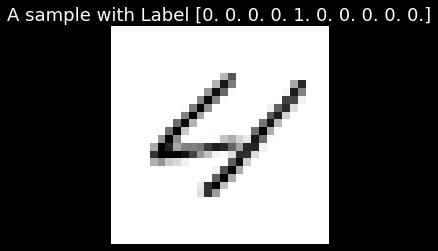

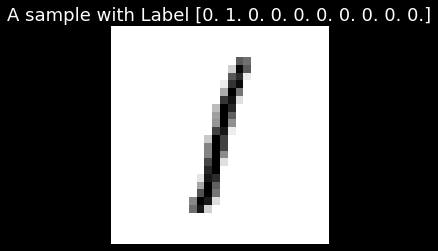

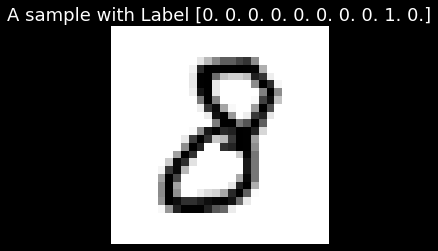

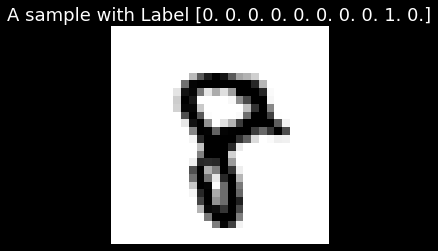

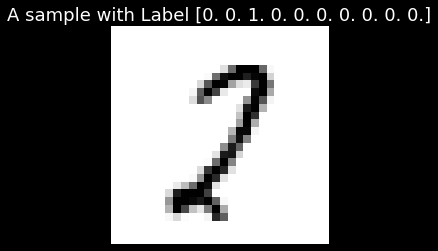

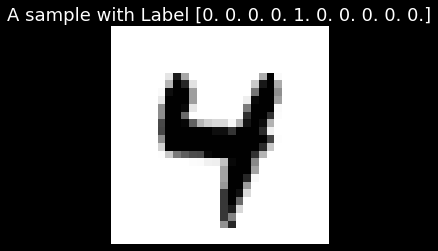

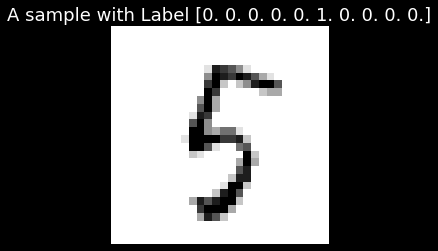

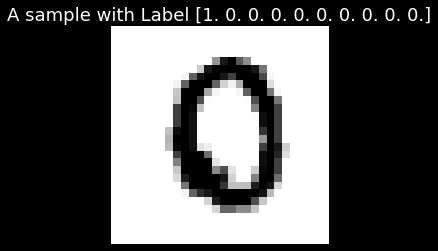

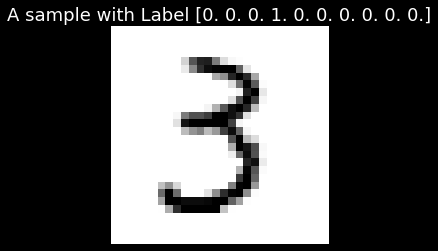

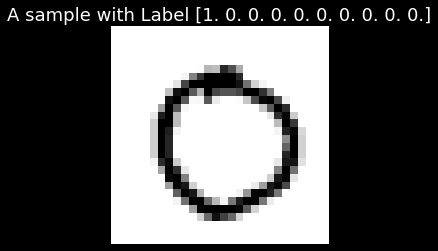

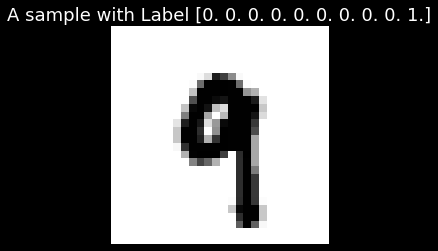

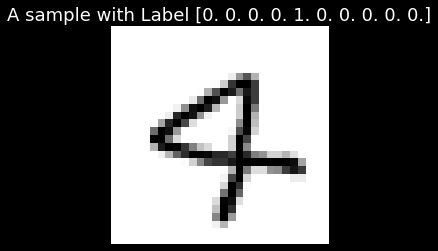

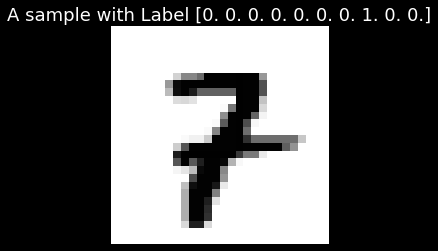

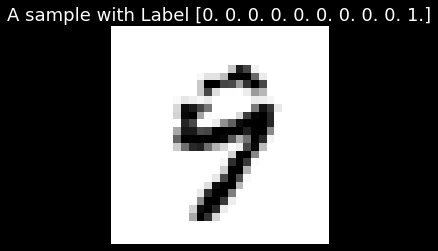

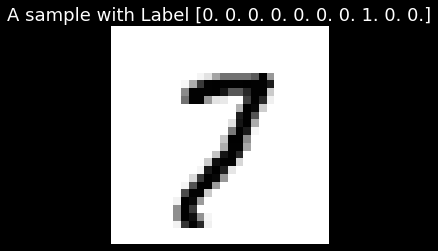

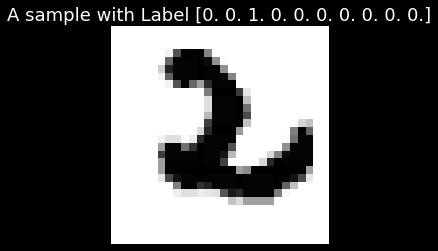

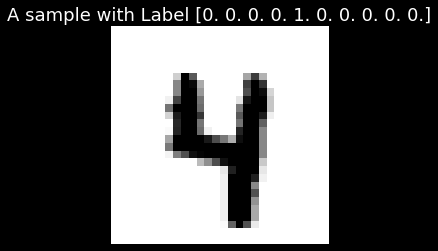

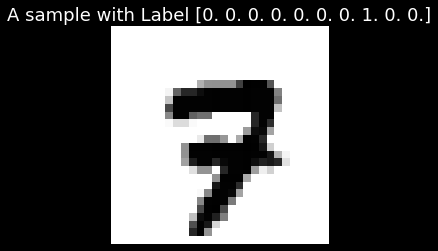

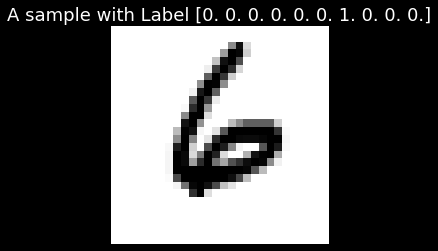

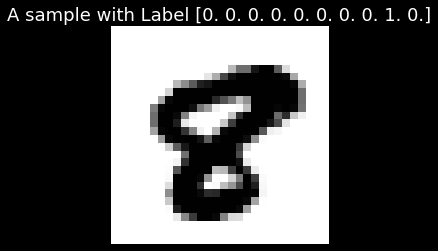

In [ ]:
#Print a random sample
for idx in range(20):
    plt.imshow(X_train[:,idx].reshape(28,28),cmap=matplotlib.cm.binary)
    plt.axis('off')
    plt.title('A sample with Label {}'.format(y_train[:,idx]))
    plt.show()
    #print(y_train[:,idx])

### Step v3.4 : Forward propagation
* Only the last layer of our network is changing.
* To add the `softmax`, we have to replace our lone, final node with a 10-unit output layer. Its final activations are the exponentials of its $z$-values, normalized across all ten such exponentials.
* So, instead of just computing $\sigma(z)$, we compute the activation, $a_i$ for each unit $i$:
$$
a_i = \dfrac{e^{z_i}}{ \sum_{j=0}^9 e^{z_j}}
$$
* In our vectorized code, the last of forward propagation will be `A2 = np.exp(Z2) / np.sum(np.exp(Z2),axis=0)`

### Step v3.5: Cost (i.e., loss) function
* The cost function now has to generalize to more than two classes. The general formula for $n$ classes is:
$$
L(y,\hat{y}) = - \sum_{i=0}^n y_i\log(\hat{y}_i)
$$
* Averaging over $m$ training samples, this becomes:
$$
L(y,\hat{y}) = - \dfrac{1}{m}\sum_{j=0}^m\sum_{i=0}^n y_i\log(\hat{y}_i)
$$
* Okay? Now, let's define the multi-class loss function that we can call categorical cross entropy loss.

In [ ]:
def compute_categorical_cross_entropy_loss(y_hat, y):
    L_sum = np.sum(np.multiply(y, np.log(y_hat)))
    m = y.shape[1]
    L = -(1/m)*L_sum
    
    return L

In [ ]:
@tf.function
def TF_compute_categorical_cross_entropy_loss(y_hat, y):
    L_sum = tf.reduce_sum(tf.multiply(y, tf.math.log(y_hat)))
    m = y.shape[1]
    #L = -(1/m)*L_sum
    L = tf.multiply(tf.negative(tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32))),L_sum)
    
    return L

### Step v3.6: Backpropagation
* Luckily it turns out that backprop is not really affected by the switch to a softmax.
* A softmax generalizes the sigmoid activation we have been using, and in such a way that the code we wrote earlier will still work.
* You can verify that by inspecting the following derivative:
$$
\dfrac{\partial L}{\partial z_i} = \hat{y}_i - y_i
$$

### Step v3.7: Build and train

In [ ]:
n_x = X_train.shape[0]   #number of variables per sample in the training set
n_h = 64                 #number of units in the hidden layer
learning_rate = 1

In [ ]:
#Weight initialization
W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(num_digits, n_h)
b2 = np.zeros((num_digits, 1))

In [ ]:
X = X_train
y = y_train

In [ ]:
max_iter = 2000

progress_bar = tqdm(range(max_iter))
for i in progress_bar:

    #Forward propagation
    Z1 = np.matmul(W1,X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2,A1) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)  #this is the softmax

    cost = compute_categorical_cross_entropy_loss(A2, y)

    #Compute all the derivatives
    dZ2 = A2-y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)
    
    #Gradient descent weight updates
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    #Debug point
    if (i % 100 == 0):
        progress_bar.set_description('Epoch [{}]: Cost [{}]'.format(i,cost))

print("\nFinal cost:", cost)

Epoch [0]: Cost [6.522889197279767]:   0%|          | 9/2000 [00:08<32:45,  1.01it/s]


KeyboardInterrupt: ignored

In [ ]:
n_x = X_train.shape[0]   #number of variables per sample in the training set
n_h = 64                 #number of units in the hidden layer
learning_rate = 1

In [ ]:
#Weight initialization
TF_W1 = tf.Variable(np.random.randn(n_h, n_x), dtype=tf.float32)
TF_b1 = tf.Variable(np.zeros((n_h, 1)), dtype=tf.float32)
TF_W2 = tf.Variable(np.random.randn(num_digits, n_h), dtype=tf.float32)
TF_b2 = tf.Variable(np.zeros((num_digits, 1)), dtype=tf.float32)

In [ ]:
TF_X = tf.Variable(X_train, dtype=tf.float32)
TF_y = tf.Variable(y_train, dtype=tf.float32)

In [ ]:
max_iter = 2000

progress_bar = tqdm(range(max_iter))
for i in progress_bar:

    #Forward propagation
    #Z1 = np.matmul(W1,X) + b1
    TF_Z1 = tf.add(tf.matmul(TF_W1, TF_X), TF_b1)
    #A1 = sigmoid(Z1)
    TF_A1 = TF_sigmoid(TF_Z1)
    #Z2 = np.matmul(W2,A1) + b2
    TF_Z2 = tf.add(tf.matmul(TF_W2, TF_A1), TF_b2)
    #A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)  #this is the softmax
    TF_A2 = tf.divide(tf.math.exp(TF_Z2), tf.reduce_sum(tf.math.exp(TF_Z2),axis=0))

    cost = TF_compute_categorical_cross_entropy_loss(TF_A2, TF_y)

    #Compute all the derivatives
    #dZ2 = A2-y
    TF_dZ2 = tf.subtract(TF_A2,TF_y)
    #dW2 = (1./m) * np.matmul(dZ2, A1.T)
    TF_dW2 = tf.multiply( tf.divide( tf.constant(1.),tf.constant(m,dtype=tf.float32)), 
                          tf.matmul(TF_dZ2, tf.transpose(TF_A1)))
    #db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)
    TF_db2 = tf.multiply( tf.divide( tf.constant(1.),tf.constant(m,dtype=tf.float32)),
                          tf.reduce_sum(TF_dZ2,axis=1,keepdims=True)
                         )

    #dA1 = np.matmul(W2.T, dZ2)
    TF_dA1 = tf.matmul(tf.transpose(TF_W2), TF_dZ2)
    #dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    TF_dZ1 = tf.multiply(tf.multiply( TF_dA1, TF_sigmoid(TF_Z1)), 
                       tf.subtract(tf.constant(1.), TF_sigmoid(TF_Z1)) )
    #dW1 = (1./m) * np.matmul(dZ1, X.T)
    TF_dW1 = tf.multiply( tf.divide(tf.constant(1.), tf.constant(m, dtype=tf.float32)),
                          tf.matmul(TF_dZ1, tf.transpose(TF_X)) )
    #db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)
    TF_db1 = tf.multiply(tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32)),
                         tf.reduce_sum(TF_dZ1, axis=1, keepdims=True))
    
    #Gradient descent weight updates
    #W2 = W2 - learning_rate * dW2
    TF_W2 = tf.subtract(TF_W2, tf.multiply(tf.constant(learning_rate,dtype=tf.float32),TF_dW2))
    #b2 = b2 - learning_rate * db2
    TF_b2 = tf.subtract(TF_b2, tf.multiply(tf.constant(learning_rate,dtype=tf.float32),TF_db2))
    #W1 = W1 - learning_rate * dW1
    TF_W1 = tf.subtract(TF_W1, tf.multiply(tf.constant(learning_rate,dtype=tf.float32),TF_dW1))
    #b1 = b1 - learning_rate * db1
    TF_b1 = tf.subtract(TF_b1, tf.multiply(tf.constant(learning_rate,dtype=tf.float32),TF_db1))

    #Debug point
    if (i % 100 == 0):
        progress_bar.set_description('Epoch [{}]: Cost [{}]'.format(i,cost))

print("\nFinal cost:", cost)

Epoch [1900]: Cost [0.22547344863414764]: 100%|██████████| 2000/2000 [00:23<00:00, 83.97it/s]


Final cost: tf.Tensor(0.22004856, shape=(), dtype=float32)


### Step v3.8 Evaluation

In [ ]:
TF_X = tf.Variable(X_test, dtype=tf.float32)
# Feed forward test dataset onto the hidden layer, with W1, b1 trained.
TF_Z1 = tf.add(tf.matmul(TF_W1, TF_X), TF_b1) #the net_in
TF_A1 = TF_sigmoid(TF_Z1)                  #activated output from the hidden layer
#now, feed forward the hidden layer output to the next layer, output layer
TF_Z2 = tf.add(tf.matmul(TF_W2,TF_A1), TF_b2)        #the net_in
TF_A2 = tf.divide( tf.math.exp(TF_Z2), tf.reduce_sum(tf.math.exp(TF_Z2), axis=0))  #softmax activated output from the output layer, 
                                              # it's the hat(y), the prediction
A2 = TF_A2.numpy() #convert it back to numpy

In [ ]:
predictions = np.argmax(A2, axis=0)  #our predictions. Please note the usage of argmax()
labels = np.argmax(y_test, axis=0)    #the ground-true class labels

In [ ]:
#Now, build the confusion matrix
conf_mat = confusion_matrix(predictions,labels)
print('Confusion matrix: \n{}'.format(conf_mat))

Confusion matrix: 
[[807   0  15   3   3   8   8   2   3   8]
 [  0 922   1   2   6   3   1   3  18   6]
 [  7   4 717  31   5   5  10  14   9   1]
 [  5   6  11 783   1  27   0   6  20  11]
 [  0   1  11   0 749  12   5   6   4  28]
 [  8   1   2  26   0 649   6   3  20   8]
 [ 10   1  13   4  12  13 799   1   8   0]
 [  1   1   7   8   2   4   0 836   1  35]
 [  8  13  21  18   4  20   2   3 713   7]
 [  6   1   3   7  29   6   0  10   6 736]]


* And the classification report below. You can see the performance is extra-ordinarily good.

In [ ]:
print('Classification report on the test set: \n{}'.format(classification_report(predictions,labels)))

Classification report on the test set: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       857
           1       0.97      0.96      0.96       962
           2       0.90      0.89      0.89       803
           3       0.89      0.90      0.89       870
           4       0.92      0.92      0.92       816
           5       0.87      0.90      0.88       723
           6       0.96      0.93      0.94       861
           7       0.95      0.93      0.94       895
           8       0.89      0.88      0.89       809
           9       0.88      0.92      0.90       804

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400



## Building a Neural Network (version 4)

* Let's improve our training algorithm from version 3.
* The main driver in this improvement is just switching from `batch gradient descent` to `mini-batch gradient descent`.
* There are 2 other smaller improvements:
    1. We will add momentum to our gradient descent algorithm.
    2. We will use clever technique to initialize all the weights of the network

### Step v4.1 the dataset loading and scaling

In [ ]:
# Load the original dataset again which contained the original labels 0-9 for each sample.
dataset = pd.read_csv(mnist_path + 'mnist-dataset/train.csv')
X = np.array(dataset.drop('label',axis=1))
y = np.array(dataset['label'])
X = X / 255   #don't forget to scale

### Step v4.2: One-hot encode the MNIST labels for each sample

* We need to one-hot encode MNIST labels for each sample; that is, each label will become 10-dimensional one-hot vector, where index $i$ will be hot (i.e., 1) if the label is $i$.
* For example, 
* a label '7' will be one-hot encoded as `[0, 0, 0, 0, 0,  0, 1, 0, 0, 0]`
* a label '1' will be one-hot encoded as `[0, 1, 0, 0, 0,  0, 0, 0, 0, 0]`
* etc.

In [ ]:
num_digits = 10
num_samples = y.shape[0]

y = y.reshape(1, num_samples)

y_new = np.eye(num_digits)[y.astype('int32')]
y_new = y_new.T.reshape(num_digits,num_samples)

### Step v4.3 : re-split, reshape, and re-shuffle the training set
* 80%-20% train-test split of the X,y dataset
* We also transform the shape of dataset so that each sample are placed in a column instead of row. This will ease matrix operations

In [ ]:
n = len(X) #total number of samples in the dataset
m = int(n*0.8) #80% of total samples will go to the training set, and rest will go to test set.
m_test = X.shape[0] - m #The rest, i.e., 20% will go to test.

In [ ]:
#Now split the X, y into (X_train,y_train), and (X_test,y_test) tuples
X_train, X_test = X[:m].T, X[m:].T
y_train, y_test = y_new[:,:m], y_new[:,m:]

In [ ]:
#And, shuffle the training set
np.random.seed(4321)
shuffle_indices = np.random.permutation(m)
X_train, y_train = X_train[:,shuffle_indices], y_train[:,shuffle_indices]

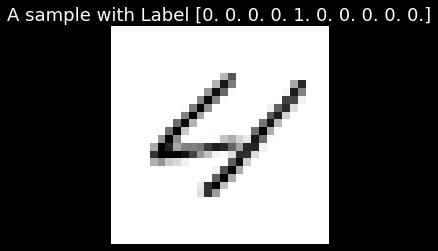

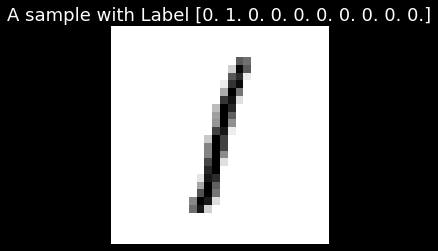

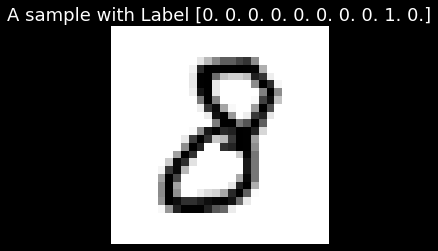

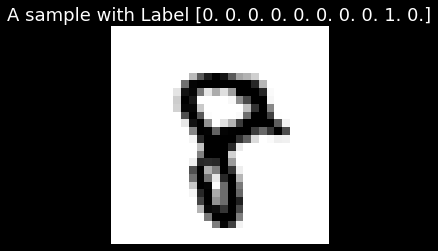

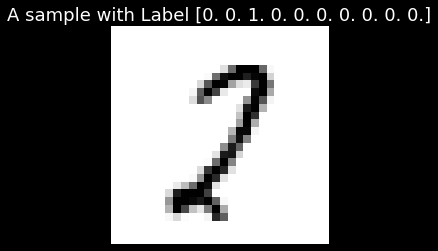

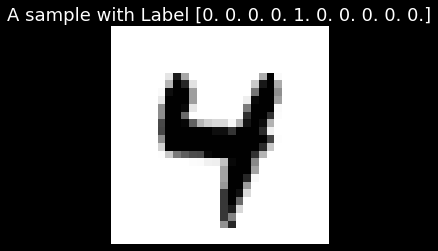

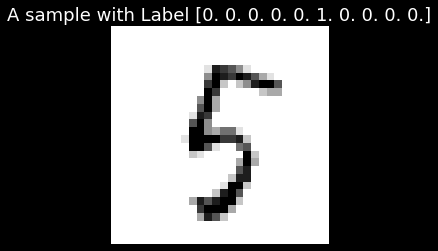

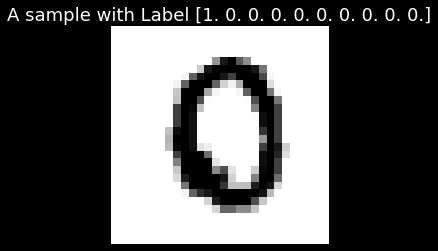

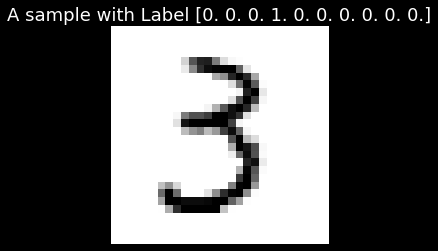

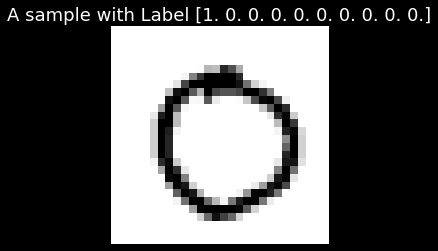

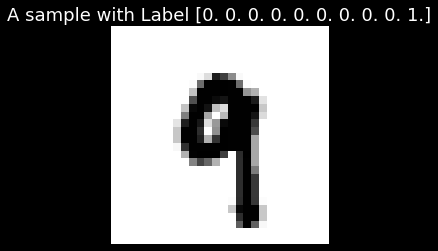

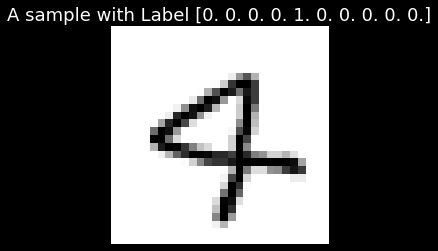

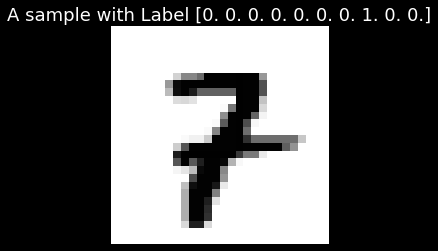

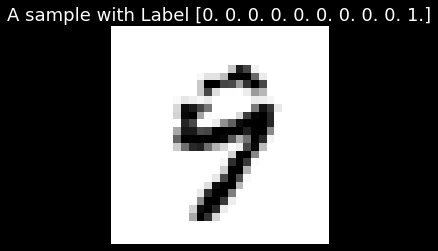

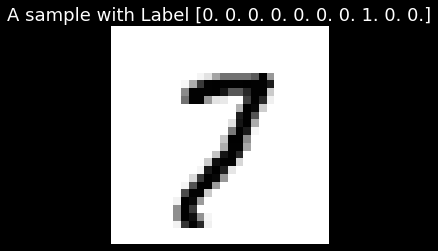

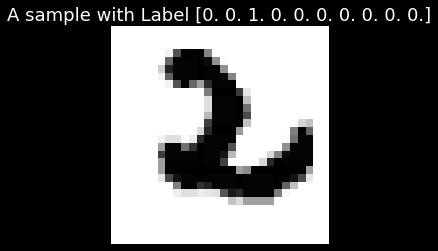

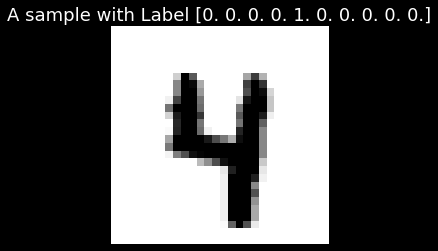

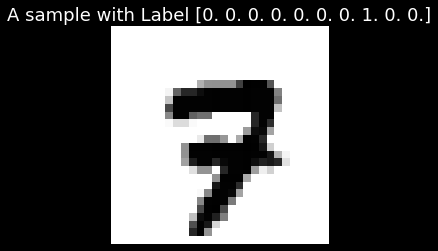

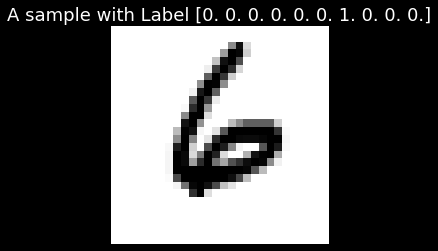

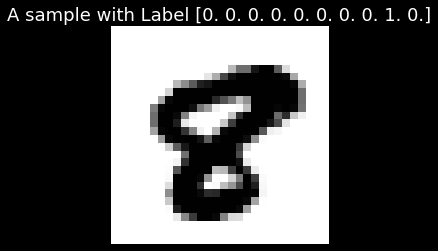

In [ ]:
#Print a random sample
for idx in range(20):
    plt.imshow(X_train[:,idx].reshape(28,28),cmap=matplotlib.cm.binary)
    plt.axis('off')
    plt.title('A sample with Label {}'.format(y_train[:,idx]))
    plt.show()
    #print(y_train[:,idx])

### Step v4.4 : defining few functions to modularize the codes we've developed before
* Last 2 functions are new, and they just put the steps of forward and backward propagation into their own functions.
    * This tidies up the training code to follow, so that we can focus on the new elements, especially the mini-batch gradient descent and the momentum.
* Also, note that in the process we introduce 3 dictionaries: `params`, `cache`, and `grads`. These are for conveniently passing information back and forth between the forward and backward passes.

In [ ]:
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

In [ ]:
## Week 05 material (with tensorflow)

""" The sigmoid function that squashes input, z into the range [0,1] """
@tf.function
def TF_sigmoid(z):
    s = tf.divide( tf.constant(1.0), tf.add(tf.constant(1.0),tf.exp(tf.negative(z))) )
    return s

In [ ]:
def compute_categorical_entropy_loss(y_hat, y):

    L_sum = np.sum(np.multiply(y, np.log(y_hat)))
    m = y.shape[1]
    L = -(1./m) * L_sum

    return L

In [ ]:
@tf.function
def TF_compute_categorical_cross_entropy_loss(y_hat, y):
    L_sum = tf.reduce_sum(tf.multiply(y, tf.math.log(y_hat)))
    m = y.shape[1]
    #L = -(1/m)*L_sum
    L = tf.multiply(tf.negative(tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32))),L_sum)
    
    return L

In [ ]:
def feed_forward(X, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache

In [ ]:
@tf.function
def TF_feed_forward(X, params):

    cache = {}

    cache["Z1"] = tf.add(tf.matmul(params["W1"], X), params["b1"])
    cache["A1"] = TF_sigmoid(cache["Z1"])
    cache["Z2"] = tf.add(tf.matmul(params["W2"], cache["A1"]), params["b2"])
    cache["A2"] = tf.divide(tf.math.exp(cache["Z2"]), tf.reduce_sum(tf.math.exp(cache["Z2"]), axis=0))

    return cache

In [ ]:
def back_propagate(X, y, params, cache):

    dZ2 = cache["A2"] - y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

In [ ]:
@tf.function
def TF_back_propagate(X, y, params, cache):

    dZ2 = tf.subtract(cache["A2"] , y)
    dW2 = tf.multiply( tf.divide(tf.constant(1.), tf.constant(m_batch,dtype=tf.float32)) , 
                      tf.matmul(dZ2, tf.transpose(cache["A1"])))
    db2 = tf.multiply( tf.divide(tf.constant(1.), tf.constant(m_batch,dtype=tf.float32)) , 
                      tf.reduce_sum(dZ2, axis=1, keepdims=True) )

    dA1 = tf.matmul(tf.transpose(params["W2"]), dZ2)
    dZ1 = tf.multiply(tf.multiply(dA1,TF_sigmoid(cache["Z1"])), 
                      tf.subtract(tf.constant(1.), TF_sigmoid(cache["Z1"])))
    dW1 = tf.multiply(tf.divide(tf.constant(1.),tf.constant(m_batch,dtype=tf.float32)), tf.matmul(dZ1, tf.transpose(X)))
    db1 = tf.multiply(tf.divide(tf.constant(1.),tf.constant(m_batch,dtype=tf.float32)), tf.reduce_sum(dZ1, axis=1, keepdims=True))

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads

### Step v4.5: Build and train

* To switch to mini-batch gradient descent, we add another `for` loop inside the pass through each epoch.
* At each pass, we randomly shuffle the training set, then iterate through it in chunks of `batch_size`, which we will arbitrarily set to `128`.

* Next, we add `momentum`. We keep a moving average of our gradients. 
    * A reference article can be found here [Link](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d)
* So, instead of updating our parameters by doing 

`params["W1"] = params["W1"] - learning_rate * grads["dW1"]`
* we do this:

`V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])`

`params["W1"] = params["W1"] - learning_rate * V_dW1'`

* Finally, we improve our weight initializations too. 
* We shrink the variance of the weights in each layer. We will set the variance for each layer to $\dfrac{1}{n}$, where $n$ is the number of inputs feeding into that layer.
* Previously, we have been using `np.random.randn()` function to get our weights initialized. And, this function draws from the standard normal distribution.
* To adjust the variance to $\dfrac{1}{n}$, we just divide by $\sqrt{n}$.
* In code, this means that instead of doing --

`np.random.randn(n_h, n_x)`

we do 

`np.random.randn(n_h,n_x) * np.sqrt(1. / n_x)`

* A reference article can be found here [Link](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

Okay, let's build and train!


In [ ]:
np.random.seed(4321)

In [ ]:

# hyperparameters
n_x = X_train.shape[0]
n_h = 64
learning_rate = 4
beta = .9
batch_size = 128
batches = -(-m // batch_size)

In [ ]:
# weight initialization
params = { "W1": np.random.randn(n_h, n_x) * np.sqrt(1. / n_x),
           "b1": np.zeros((n_h, 1)) * np.sqrt(1. / n_x),
           "W2": np.random.randn(num_digits, n_h) * np.sqrt(1. / n_h),
           "b2": np.zeros((num_digits, 1)) * np.sqrt(1. / n_h) }

V_dW1 = np.zeros(params["W1"].shape)
V_db1 = np.zeros(params["b1"].shape)
V_dW2 = np.zeros(params["W2"].shape)
V_db2 = np.zeros(params["b2"].shape)

In [ ]:
max_iter = 20

progress_bar = tqdm(range(max_iter))
for i in progress_bar:

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    y_train_shuffled = y_train[:, permutation]

    for j in range(batches):
        #Determine the training batch
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        y = y_train_shuffled[:, begin:end]
        m_batch = end - begin

        #forward propagation
        cache = feed_forward(X, params)
        
        #calculating the gradients
        grads = back_propagate(X, y, params, cache)

        #updating the momentum
        V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])
        V_db1 = (beta * V_db1 + (1. - beta) * grads["db1"])
        V_dW2 = (beta * V_dW2 + (1. - beta) * grads["dW2"])
        V_db2 = (beta * V_db2 + (1. - beta) * grads["db2"])

        #weight updates
        params["W1"] = params["W1"] - learning_rate * V_dW1
        params["b1"] = params["b1"] - learning_rate * V_db1
        params["W2"] = params["W2"] - learning_rate * V_dW2
        params["b2"] = params["b2"] - learning_rate * V_db2

    #training cost at this iteration
    cache = feed_forward(X_train, params)
    train_cost = compute_categorical_cross_entropy_loss(cache["A2"], y_train )
    #test cost at this iteration
    cache = feed_forward(X_test, params)
    test_cost = compute_categorical_cross_entropy_loss(cache["A2"], y_test )
    
    #debug point
    progress_bar.set_description("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

print("\nDone.")

Epoch 5: training cost = 0.05970921105435164, test cost = 0.11186532861695749:  25%|██▌       | 5/20 [00:12<00:36,  2.41s/it]


KeyboardInterrupt: ignored

In [ ]:

# hyperparameters
n_x = X_train.shape[0]
n_h = 64
learning_rate = 4
beta = .9
batch_size = 128
batches = -(-m // batch_size)

In [ ]:
# weight initialization
params = { "W1": tf.Variable(np.random.randn(n_h, n_x) * np.sqrt(1. / n_x), dtype=tf.float32),
           "b1": tf.Variable(np.zeros((n_h, 1)) * np.sqrt(1. / n_x), dtype=tf.float32),
           "W2": tf.Variable(np.random.randn(num_digits, n_h) * np.sqrt(1. / n_h), dtype=tf.float32),
           "b2": tf.Variable(np.zeros((num_digits, 1)) * np.sqrt(1. / n_h), dtype=tf.float32) }

V_dW1 = tf.zeros(params["W1"].shape)
V_db1 = tf.zeros(params["b1"].shape)
V_dW2 = tf.zeros(params["W2"].shape)
V_db2 = tf.zeros(params["b2"].shape)

In [ ]:
max_iter = 20

progress_bar = tqdm(range(max_iter))
for i in progress_bar:

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    y_train_shuffled = y_train[:, permutation]

    for j in range(batches):
        #Determine the training batch
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = tf.Variable(X_train_shuffled[:, begin:end], dtype=tf.float32)
        y = tf.Variable(y_train_shuffled[:, begin:end], dtype=tf.float32)
        m_batch = end - begin

        #forward propagation
        cache = TF_feed_forward(X, params)
        
        #calculating the gradients
        grads = TF_back_propagate(X, y, params, cache)

        #updating the momentum
        V_dW1 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_dW1),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["dW1"]))
        V_db1 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_db1),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["db1"]))
        V_dW2 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_dW2),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["dW2"]))
        V_db2 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_db2),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["db2"]))

        #weight updates
        params["W1"] = tf.subtract(params["W1"], tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_dW1))
        params["b1"] = tf.subtract(params["b1"], tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_db1))
        params["W2"] = tf.subtract(params["W2"], tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_dW2))
        params["b2"] = tf.subtract(params["b2"], tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_db2))


    #training cost at this iteration
    cache = TF_feed_forward(tf.Variable(X_train, dtype=tf.float32), params)
    train_cost = TF_compute_categorical_cross_entropy_loss(cache["A2"], tf.Variable(y_train, dtype=tf.float32) )
    #test cost at this iteration
    cache = TF_feed_forward(tf.Variable(X_test, dtype=tf.float32), params)
    test_cost = TF_compute_categorical_cross_entropy_loss(cache["A2"], tf.Variable(y_test, dtype=tf.float32) )
    
    #debug point
    progress_bar.set_description("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

print("\nDone.")

Epoch 20: training cost = 0.005303682293742895, test cost = 0.10298463702201843: 100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


Done.


### Step v4.6 Evaluation

In [ ]:
#predict the test set
cache = TF_feed_forward(tf.Variable(X_test, dtype=tf.float32), params)
predictions = np.argmax(cache["A2"].numpy(), axis=0)
labels = np.argmax(y_test, axis=0)


In [ ]:
#Now, build the confusion matrix
conf_mat = confusion_matrix(predictions,labels)
print('Confusion matrix: \n{}'.format(conf_mat))

Confusion matrix: 
[[840   0   6   2   1   3   3   1   2   4]
 [  0 940   1   3   4   3   2   1   8   3]
 [  2   2 780   6   2   1   2   6   0   1]
 [  1   1   1 849   0   7   0   3   3   9]
 [  0   1   2   0 786   2   2   0   3  11]
 [  0   1   3  11   0 721   1   2   6   6]
 [  4   0   1   0   3   5 821   0   5   0]
 [  0   2   3   4   0   0   0 867   0   9]
 [  5   3   2   5   3   2   0   1 772   7]
 [  0   0   2   2  12   3   0   3   3 790]]


* And the classification report below. You can see the performance is extra-ordinarily good.

In [ ]:
print('Classification report on the test set: \n{}'.format(classification_report(predictions,labels)))

Classification report on the test set: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       862
           1       0.99      0.97      0.98       965
           2       0.97      0.97      0.97       802
           3       0.96      0.97      0.97       874
           4       0.97      0.97      0.97       807
           5       0.97      0.96      0.96       751
           6       0.99      0.98      0.98       839
           7       0.98      0.98      0.98       885
           8       0.96      0.96      0.96       800
           9       0.94      0.97      0.95       815

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



## Building a Neural Network (version 5)

* Let's explore Tensorflow's automatic differentation

### Step v5.1 the dataset loading and scaling

In [ ]:
# Load the original dataset again which contained the original labels 0-9 for each sample.
dataset = pd.read_csv(mnist_path + 'mnist-dataset/train.csv')
X = np.array(dataset.drop('label',axis=1))
y = np.array(dataset['label'])
X = X / 255   #don't forget to scale

### Step v5.2: One-hot encode the MNIST labels for each sample

* We need to one-hot encode MNIST labels for each sample; that is, each label will become 10-dimensional one-hot vector, where index $i$ will be hot (i.e., 1) if the label is $i$.
* For example, 
* a label '7' will be one-hot encoded as `[0, 0, 0, 0, 0,  0, 1, 0, 0, 0]`
* a label '1' will be one-hot encoded as `[0, 1, 0, 0, 0,  0, 0, 0, 0, 0]`
* etc.

In [ ]:
num_digits = 10
num_samples = y.shape[0]

y = y.reshape(1, num_samples)

y_new = np.eye(num_digits)[y.astype('int32')]
y_new = y_new.T.reshape(num_digits,num_samples)

### Step v5.3 : re-split, reshape, and re-shuffle the training set
* 80%-20% train-test split of the X,y dataset
* We also transform the shape of dataset so that each sample are placed in a column instead of row. This will ease matrix operations

In [ ]:
n = len(X) #total number of samples in the dataset
m = int(n*0.8) #80% of total samples will go to the training set, and rest will go to test set.
m_test = X.shape[0] - m #The rest, i.e., 20% will go to test.

In [ ]:
#Now split the X, y into (X_train,y_train), and (X_test,y_test) tuples
X_train, X_test = X[:m].T, X[m:].T
y_train, y_test = y_new[:,:m], y_new[:,m:]

In [ ]:
#And, shuffle the training set
np.random.seed(4321)
shuffle_indices = np.random.permutation(m)
X_train, y_train = X_train[:,shuffle_indices], y_train[:,shuffle_indices]

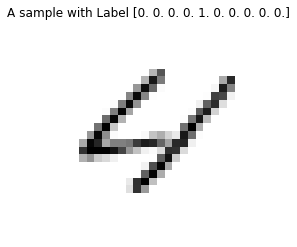

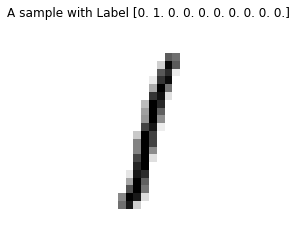

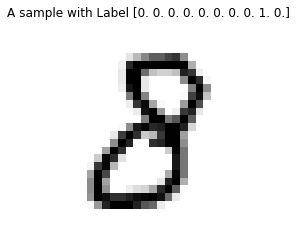

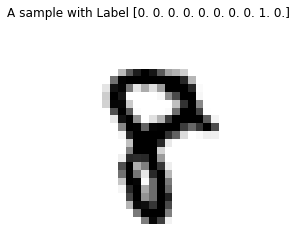

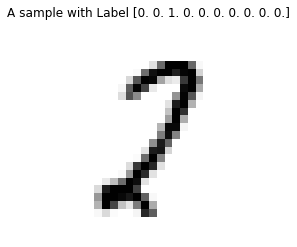

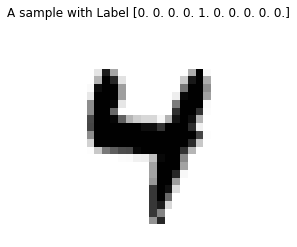

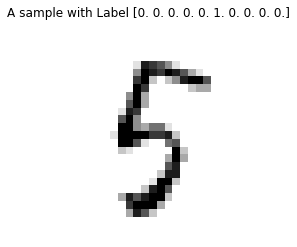

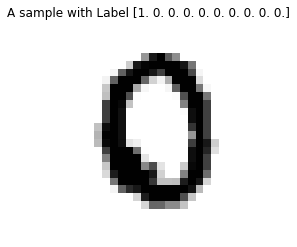

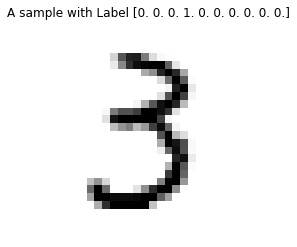

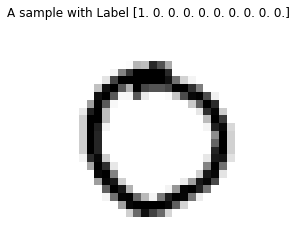

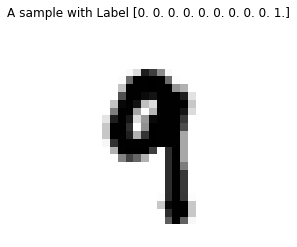

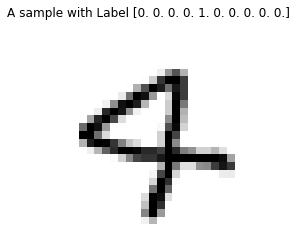

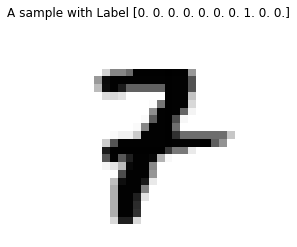

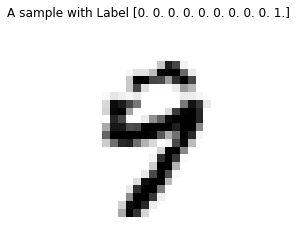

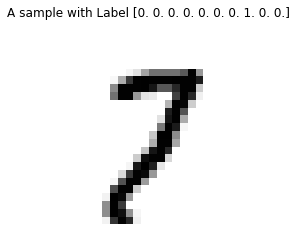

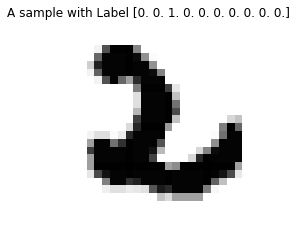

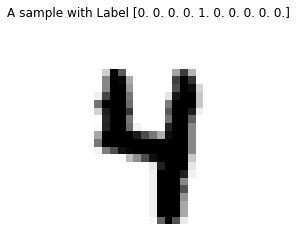

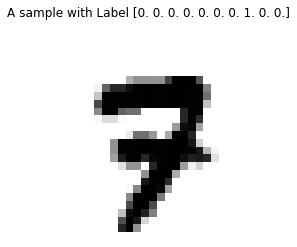

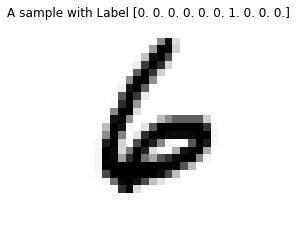

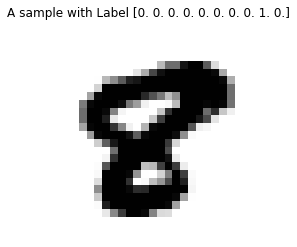

In [ ]:
#Print a random sample
for idx in range(20):
    plt.imshow(X_train[:,idx].reshape(28,28),cmap=matplotlib.cm.binary)
    plt.axis('off')
    plt.title('A sample with Label {}'.format(y_train[:,idx]))
    plt.show()
    #print(y_train[:,idx])

### Step v5.4 : defining few functions to modularize the codes we've developed before
* Last 2 functions are new, and they just put the steps of forward and backward propagation into their own functions.
    * This tidies up the training code to follow, so that we can focus on the new elements, especially the mini-batch gradient descent and the momentum.
* Also, note that in the process we introduce 3 dictionaries: `params`, `cache`, and `grads`. These are for conveniently passing information back and forth between the forward and backward passes.

In [ ]:
## Week 05 material (with tensorflow)

""" The sigmoid function that squashes input, z into the range [0,1] """
@tf.function
def TF_sigmoid(z):
    s = tf.divide( tf.constant(1.0), tf.add(tf.constant(1.0),tf.exp(tf.negative(z))) )
    return s

In [ ]:
@tf.function
def TF_compute_categorical_cross_entropy_loss(y_hat, y):
    L_sum = tf.reduce_sum(tf.multiply(y, tf.math.log(y_hat)))
    m = y.shape[1]
    #L = -(1/m)*L_sum
    L = tf.multiply(tf.negative(tf.divide(tf.constant(1.),tf.constant(m,dtype=tf.float32))),L_sum)
    
    return L

In [ ]:
@tf.function
def TF_feed_forward(X, params):

    cache = {}

    cache["Z1"] = tf.add(tf.matmul(params["W1"], X), params["b1"])
    cache["A1"] = TF_sigmoid(cache["Z1"])
    cache["Z2"] = tf.add(tf.matmul(params["W2"], cache["A1"]), params["b2"])
    cache["A2"] = tf.divide(tf.math.exp(cache["Z2"]), tf.reduce_sum(tf.math.exp(cache["Z2"]), axis=0))

    return cache

### Step v5.5: Build and train

* To switch to mini-batch gradient descent, we add another `for` loop inside the pass through each epoch.
* At each pass, we randomly shuffle the training set, then iterate through it in chunks of `batch_size`, which we will arbitrarily set to `128`.

* Next, we add `momentum`. We keep a moving average of our gradients. 
    * A reference article can be found here [Link](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d)
* So, instead of updating our parameters by doing 

`params["W1"] = params["W1"] - learning_rate * grads["dW1"]`
* we do this:

`V_dW1 = (beta * V_dW1 + (1. - beta) * grads["dW1"])`

`params["W1"] = params["W1"] - learning_rate * V_dW1'`

* Finally, we improve our weight initializations too. 
* We shrink the variance of the weights in each layer. We will set the variance for each layer to $\dfrac{1}{n}$, where $n$ is the number of inputs feeding into that layer.
* Previously, we have been using `np.random.randn()` function to get our weights initialized. And, this function draws from the standard normal distribution.
* To adjust the variance to $\dfrac{1}{n}$, we just divide by $\sqrt{n}$.
* In code, this means that instead of doing --

`np.random.randn(n_h, n_x)`

we do 

`np.random.randn(n_h,n_x) * np.sqrt(1. / n_x)`

* A reference article can be found here [Link](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

Okay, let's build and train!


In [ ]:
# hyperparameters
n_x = X_train.shape[0]
n_h = 64
learning_rate = 4
beta = .9
batch_size = 128
batches = -(-m // batch_size)

In [ ]:
# weight initialization
W1 = tf.Variable(np.random.randn(n_h, n_x) * np.sqrt(1. / n_x), dtype=tf.float32, trainable=True)
b1 = tf.Variable(np.zeros((n_h, 1)) * np.sqrt(1. / n_x), dtype=tf.float32, trainable=True)
W2 = tf.Variable(np.random.randn(num_digits, n_h) * np.sqrt(1. / n_h), dtype=tf.float32, trainable=True)
b2 = tf.Variable(np.zeros((num_digits, 1)) * np.sqrt(1. / n_h), dtype=tf.float32, trainable=True)

V_dW1 = tf.zeros(W1.shape)
V_db1 = tf.zeros(b1.shape)
V_dW2 = tf.zeros(W2.shape)
V_db2 = tf.zeros(b2.shape)

In [ ]:
max_iter = 20

progress_bar = tqdm(range(max_iter))
for i in progress_bar:

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    y_train_shuffled = y_train[:, permutation]

    for j in range(batches):
        #Determine the training batch
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = tf.Variable(X_train_shuffled[:, begin:end], dtype=tf.float32, trainable=False)
        y = tf.Variable(y_train_shuffled[:, begin:end], dtype=tf.float32, trainable=False)
        m_batch = end - begin

        #forward propagation
        with tf.GradientTape(watch_accessed_variables=False) as tape: #disable watching all variables
          tape.watch([W1, b1, W2, b2]) #instead connect the gradient for only these 4 variables

          Z1 = tf.add(tf.matmul(W1, X), b1)
          A1 = TF_sigmoid(Z1)
          Z2 = tf.add(tf.matmul(W2, A1), b2)
          A2 = tf.divide(tf.math.exp(Z2), tf.reduce_sum(tf.math.exp(Z2), axis=0))

          #computing cost
          L_sum = tf.reduce_sum(tf.multiply(y, tf.math.log(A2)))
          cost = tf.multiply(tf.negative(tf.divide(tf.constant(1.),tf.constant(m_batch,dtype=tf.float32))),L_sum)
                
        #calculating the gradients (with automatic differentiation)
        [dW1, db1, dW2, db2] = tape.gradient(cost, [W1, b1, W2, b2])
        grads = {'W1': dW1,'b1': db1, 'W2': dW2,'b2': db2}

        #updating the momentum
        V_dW1 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_dW1),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["W1"]))
        V_db1 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_db1),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["b1"]))
        V_dW2 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_dW2),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["W2"]))
        V_db2 = tf.add(tf.multiply(tf.constant(beta,dtype=tf.float32),V_db2),
                       tf.multiply(tf.subtract( tf.constant(1.), tf.constant(beta,dtype=tf.float32)), grads["b2"]))

        #weight updates
        W1 = tf.subtract(W1, tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_dW1))
        b1 = tf.subtract(b1, tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_db1))
        W2 = tf.subtract(W2, tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_dW2))
        b2 = tf.subtract(b2, tf.multiply(tf.constant(learning_rate, dtype=tf.float32), V_db2))

    #training cost at this iteration
    cache = TF_feed_forward(tf.Variable(X_train, dtype=tf.float32), params={"W1":W1,"b1":b1, "W2":W2, "b2":b2})
    train_cost = TF_compute_categorical_cross_entropy_loss(cache["A2"], tf.Variable(y_train, dtype=tf.float32) )

    #test cost at this iteration
    cache = TF_feed_forward(tf.Variable(X_test, dtype=tf.float32), params={"W1":W1,"b1":b1, "W2":W2, "b2":b2})
    test_cost = TF_compute_categorical_cross_entropy_loss(cache["A2"], tf.Variable(y_test, dtype=tf.float32) )
    
    #debug point
    progress_bar.set_description("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

print("\nDone.")

Epoch 20: training cost = 0.005960743874311447, test cost = 0.10360763967037201: 100%|██████████| 20/20 [01:47<00:00,  5.38s/it]


Done.


**bold text**### Step v5.6 Evaluation

In [ ]:
#predict the test set
cache = TF_feed_forward(tf.Variable(X_test, dtype=tf.float32), params={"W1":W1,"b1":b1, "W2":W2, "b2":b2})
predictions = np.argmax(cache["A2"].numpy(), axis=0)
labels = np.argmax(y_test, axis=0)


In [ ]:
#Now, build the confusion matrix
conf_mat = confusion_matrix(predictions,labels)
print('Confusion matrix: \n{}'.format(conf_mat))

Confusion matrix: 
[[838   0   3   2   0   4   3   2   1   4]
 [  0 938   0   1   4   1   2   1   5   2]
 [  1   1 778   4   2   4   1   3   1   2]
 [  2   1   3 853   1   7   0   3   2   6]
 [  0   0   2   0 776   3   1   0   1   8]
 [  1   0   0  12   0 714   2   2   6   2]
 [  7   0   2   0   3   4 820   0   3   1]
 [  0   3   3   2   1   1   1 869   0   8]
 [  3   6   7   4   5   5   1   2 783   5]
 [  0   1   3   4  19   4   0   2   0 802]]


* And the classification report below. You can see the performance is extra-ordinarily good.

In [ ]:
print('Classification report on the test set: \n{}'.format(classification_report(predictions,labels)))

Classification report on the test set: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       857
           1       0.99      0.98      0.99       954
           2       0.97      0.98      0.97       797
           3       0.97      0.97      0.97       878
           4       0.96      0.98      0.97       791
           5       0.96      0.97      0.96       739
           6       0.99      0.98      0.98       840
           7       0.98      0.98      0.98       888
           8       0.98      0.95      0.96       821
           9       0.95      0.96      0.96       835

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



## Building a Neural Network (version 6)

* Let's explore Tensorflow's Keras wrapper

### Step v6.1 the dataset loading and scaling

In [ ]:
# Load the original dataset again which contained the original labels 0-9 for each sample.
dataset = pd.read_csv(mnist_path + 'mnist-dataset/train.csv')
X = np.array(dataset.drop('label',axis=1))
y = np.array(dataset['label'])
X = X / 255   #don't forget to scale

### Step v6.2: One-hot encode the MNIST labels for each sample

* We need to one-hot encode MNIST labels for each sample; that is, each label will become 10-dimensional one-hot vector, where index $i$ will be hot (i.e., 1) if the label is $i$.
* For example, 
* a label '7' will be one-hot encoded as `[0, 0, 0, 0, 0,  0, 1, 0, 0, 0]`
* a label '1' will be one-hot encoded as `[0, 1, 0, 0, 0,  0, 0, 0, 0, 0]`
* etc.

In [ ]:
num_digits = 10
num_samples = y.shape[0]

y = y.reshape(1, num_samples)

y_new = np.eye(num_digits)[y.astype('int32')]
y_new = y_new.T.reshape(num_digits,num_samples)

### Step v6.3 : re-split, reshape, and re-shuffle the training set
* 80%-20% train-test split of the X,y dataset
* We also transform the shape of dataset so that each sample are placed in a column instead of row. This will ease matrix operations

In [ ]:
n = len(X) #total number of samples in the dataset
m = int(n*0.8) #80% of total samples will go to the training set, and rest will go to test set.
m_test = X.shape[0] - m #The rest, i.e., 20% will go to test.

In [ ]:
#Now split the X, y into (X_train,y_train), and (X_test,y_test) tuples
X_train, X_test = X[:m].T, X[m:].T
y_train, y_test = y_new[:,:m], y_new[:,m:]

In [ ]:
X_train.shape

(784, 33600)

In [ ]:
#And, shuffle the training set
np.random.seed(4321)
shuffle_indices = np.random.permutation(m)
X_train, y_train = X_train[:,shuffle_indices], y_train[:,shuffle_indices]

### Step v6.4: Build and train

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:
# hyperparameters
n_x = X_train.shape[0]
n_h = 64
batch_size = 128

In [ ]:
# define the 784-256-128-10 architecture using Keras
model = Sequential()
model.add(Dense(n_h, input_shape=(n_x,), activation="sigmoid"))
model.add(Dense(10, activation="softmax"))

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [ ]:
model.compile(
  optimizer=adam,
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
model.fit(
  X_train.T, # training data
  y_train.T, # training targets
  epochs=20,
  batch_size=batch_size,
)

Epoch 1/20
263/263 [==============================] - 2s 4ms/step - loss: 0.9773 - accuracy: 0.7903
Epoch 2/20
263/263 [==============================] - 1s 4ms/step - loss: 0.4112 - accuracy: 0.8993
Epoch 3/20
263/263 [==============================] - 1s 4ms/step - loss: 0.3147 - accuracy: 0.9145
Epoch 4/20
263/263 [==============================] - 1s 4ms/step - loss: 0.2689 - accuracy: 0.9255
Epoch 5/20
263/263 [==============================] - 1s 4ms/step - loss: 0.2389 - accuracy: 0.9334
Epoch 6/20
263/263 [==============================] - 1s 4ms/step - loss: 0.2150 - accuracy: 0.9412
Epoch 7/20
263/263 [==============================] - 1s 4ms/step - loss: 0.1966 - accuracy: 0.9452
Epoch 8/20
263/263 [==============================] - 1s 4ms/step - loss: 0.1805 - accuracy: 0.9493
Epoch 9/20
263/263 [==============================] - 1s 4ms/step - loss: 0.1676 - accuracy: 0.9537
Epoch 10/20
263/263 [==============================] - 1s 4ms/step - loss: 0.1560 - accuracy: 0.9562

### Step v6.6 Evaluation

In [ ]:
#predict the test set
prediction_scores = model.predict(X_test.T, batch_size=128)
predictions = np.argmax(prediction_scores,axis=1)
labels = np.argmax(y_test, axis=0)


In [ ]:
#Now, build the confusion matrix
conf_mat = confusion_matrix(predictions,labels)
print('Confusion matrix: \n{}'.format(conf_mat))

Confusion matrix: 
[[831   0   4   3   1   4   5   2   1   6]
 [  0 932   2   1   7   3   2   1  13   5]
 [  4   2 765   8   2   5   4   7   2   1]
 [  0   4   6 846   0  11   0   3   3  10]
 [  1   0   7   0 769   4   3   1   2  17]
 [  1   1   2  11   1 698   3   1   6   4]
 [  6   0   5   0   9   3 812   0   1   0]
 [  2   3   4   5   0   1   0 864   0  10]
 [  6   7   4   5   4  12   2   2 771   6]
 [  1   1   2   3  18   6   0   3   3 781]]


* And the classification report below. You can see the performance is extra-ordinarily good.

In [ ]:
print('Classification report on the test set: \n{}'.format(classification_report(predictions,labels)))

Classification report on the test set: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       857
           1       0.98      0.96      0.97       966
           2       0.96      0.96      0.96       800
           3       0.96      0.96      0.96       883
           4       0.95      0.96      0.95       804
           5       0.93      0.96      0.95       728
           6       0.98      0.97      0.97       836
           7       0.98      0.97      0.97       889
           8       0.96      0.94      0.95       819
           9       0.93      0.95      0.94       818

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



## That's all Folks!